## Introduccion

In [2]:
options(warn = -1)
install.packages("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
options(warn = -1)
library(pacman)

p_load("data.table","dplyr","caret","scales","ggplot2",
    "dataPreparation","knitr","lubridate","inspectdf",
    "psych","corrplot","forcats","questionr","KableExtra",
    "stringi","stringr","ggpubr","tictoc","ggeasy","fastDummies",
    "magrittr","ranger","purrr","tidyverse","MLmetrics",'xgboost','png')




```
Juntaremos el train_set y el test_set y los labels, para efectuar los mismos cambios.
```



In [43]:
dataInput <- fread("training_set_values.csv",nThread = 2) # leer variables independientes de entrenamiento
trgt <- fread("training_set_labels.csv",nThread = 2) # leer variable dependiente status group
test <- fread("test_set_values.csv",nThread = 2) # leer dataset sobre el que hacemos las predicciones

DF_def = merge(dataInput, trgt, by = "id") # fusionamos train set y target con el id.
test$status_group = 'tst' #añadimos una columna target al conjunto de prueba. 

In [44]:
DF= rbind(DF_def,test) #fusionamos los dos conjuntos
tail(DF_def,3) #veamos una parte del dataframe
input <- DF #creamos un doble del dataframe, sobre el que realizar los cambios.

id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,⋯,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
<int>,<dbl>,<date>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
74243,0,2012-11-13,Ministry Of Water,1188,Hesawa,33.96354,-1.429477,Kwa Wambura Msege,0,⋯,soft,good,enough,enough,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
74246,50,2011-03-07,Ruthe,1428,Ruthe,35.63048,-7.710549,none,0,⋯,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
74247,50,2013-02-16,Mission,965,DWE,35.43300,-10.639270,Kwa Mapunda,0,⋯,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional


In [ ]:
#mostramos la estructura del dataset.
# se ven multiples variables con un tipo incorrecto
str(input)

Classes ‘data.table’ and 'data.frame':	74250 obs. of  42 variables:
 $ id                   : int  0 1 2 3 4 5 6 7 8 9 ...
 $ amount_tsh           : num  0 0 0 10 0 50 0 0 0 0 ...
 $ date_recorded        : IDate, format: "2012-11-13" "2011-03-05" ...
 $ funder               : chr  "Tasaf" "Shipo" "Lvia" "Germany Republi" ...
 $ gps_height           : int  0 1978 0 1639 0 28 0 0 0 0 ...
 $ installer            : chr  "TASAF" "SHIPO" "LVIA" "CES" ...
 $ longitude            : num  33.1 34.8 36.1 37.1 36.2 ...
 $ latitude             : num  -5.12 -9.4 -6.28 -3.19 -6.1 ...
 $ wpt_name             : chr  "Mratibu" "none" "Bombani" "Area 7 Namba 5" ...
 $ num_private          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ basin                : chr  "Lake Tanganyika" "Rufiji" "Wami / Ruvu" "Pangani" ...
 $ subvillage           : chr  "Majengo" "Magoda C" "Songambele" "Urereni" ...
 $ region               : chr  "Tabora" "Iringa" "Dodoma" "Kilimanjaro" ...
 $ region_code          : int  14 11 1 3 1 60 17 



```
La exploracion la haremos sobre input, que no incluye es test_set_values,
y los cambios los realizaremos sobre DF.
```



##Categoricas



```
Que comprobar?
1- Tipos de variables
2- Valores mal codificados
3- Valores fuera de rango
4- Variables nominales o Factores con categorías minoritarias.
    Outliers (incidencia y conversión a missing)
    Missings (incidencia e imputación)
```





```
podemos ver que hay varias variables con el formato de dato incorrecto
```



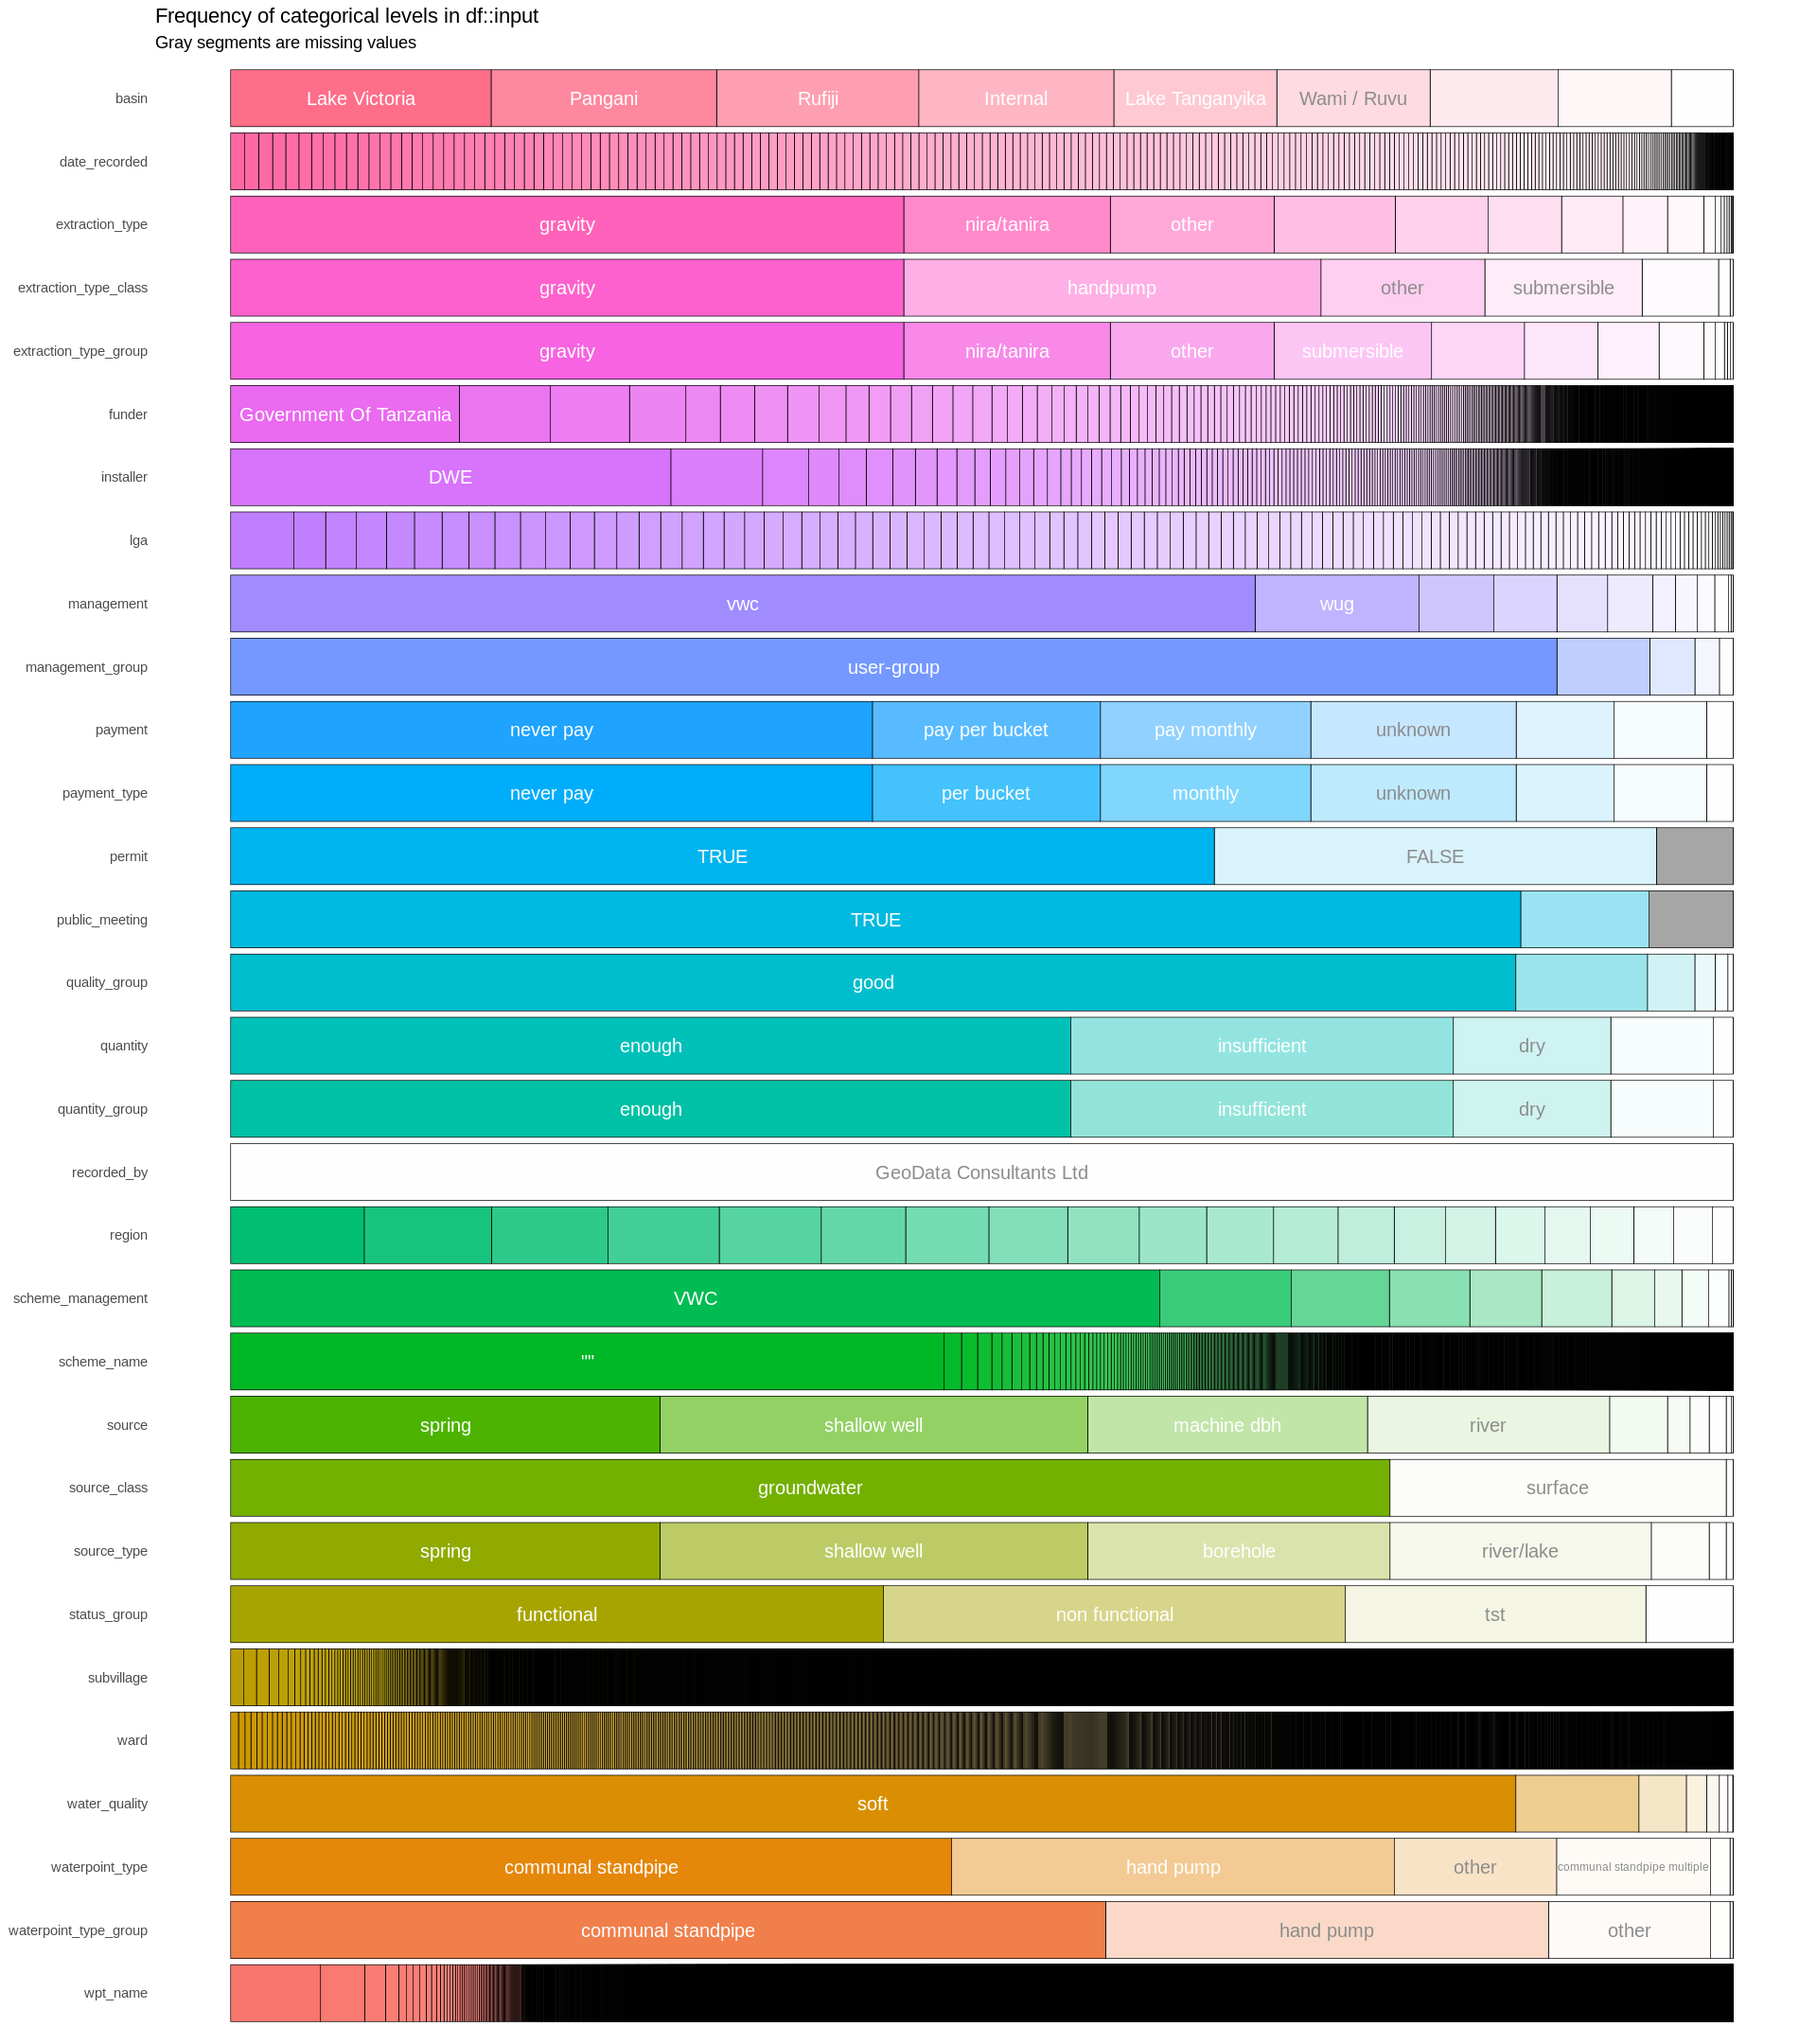

In [7]:
options(repr.plot.width=16, repr.plot.height=18)

# inspeccionamos las variables que el programa reconoce como categoricas.
# columnas de inspect_cat: 'col_name''cnt''common''common_pcnt''levels'
catg_inpct <- inspect_cat(input)
show_plot(catg_inpct)



```
Podemos observar que las proporciones entre  multiples variables son identicas o casi. Puede significar presencia de duplicados.

```




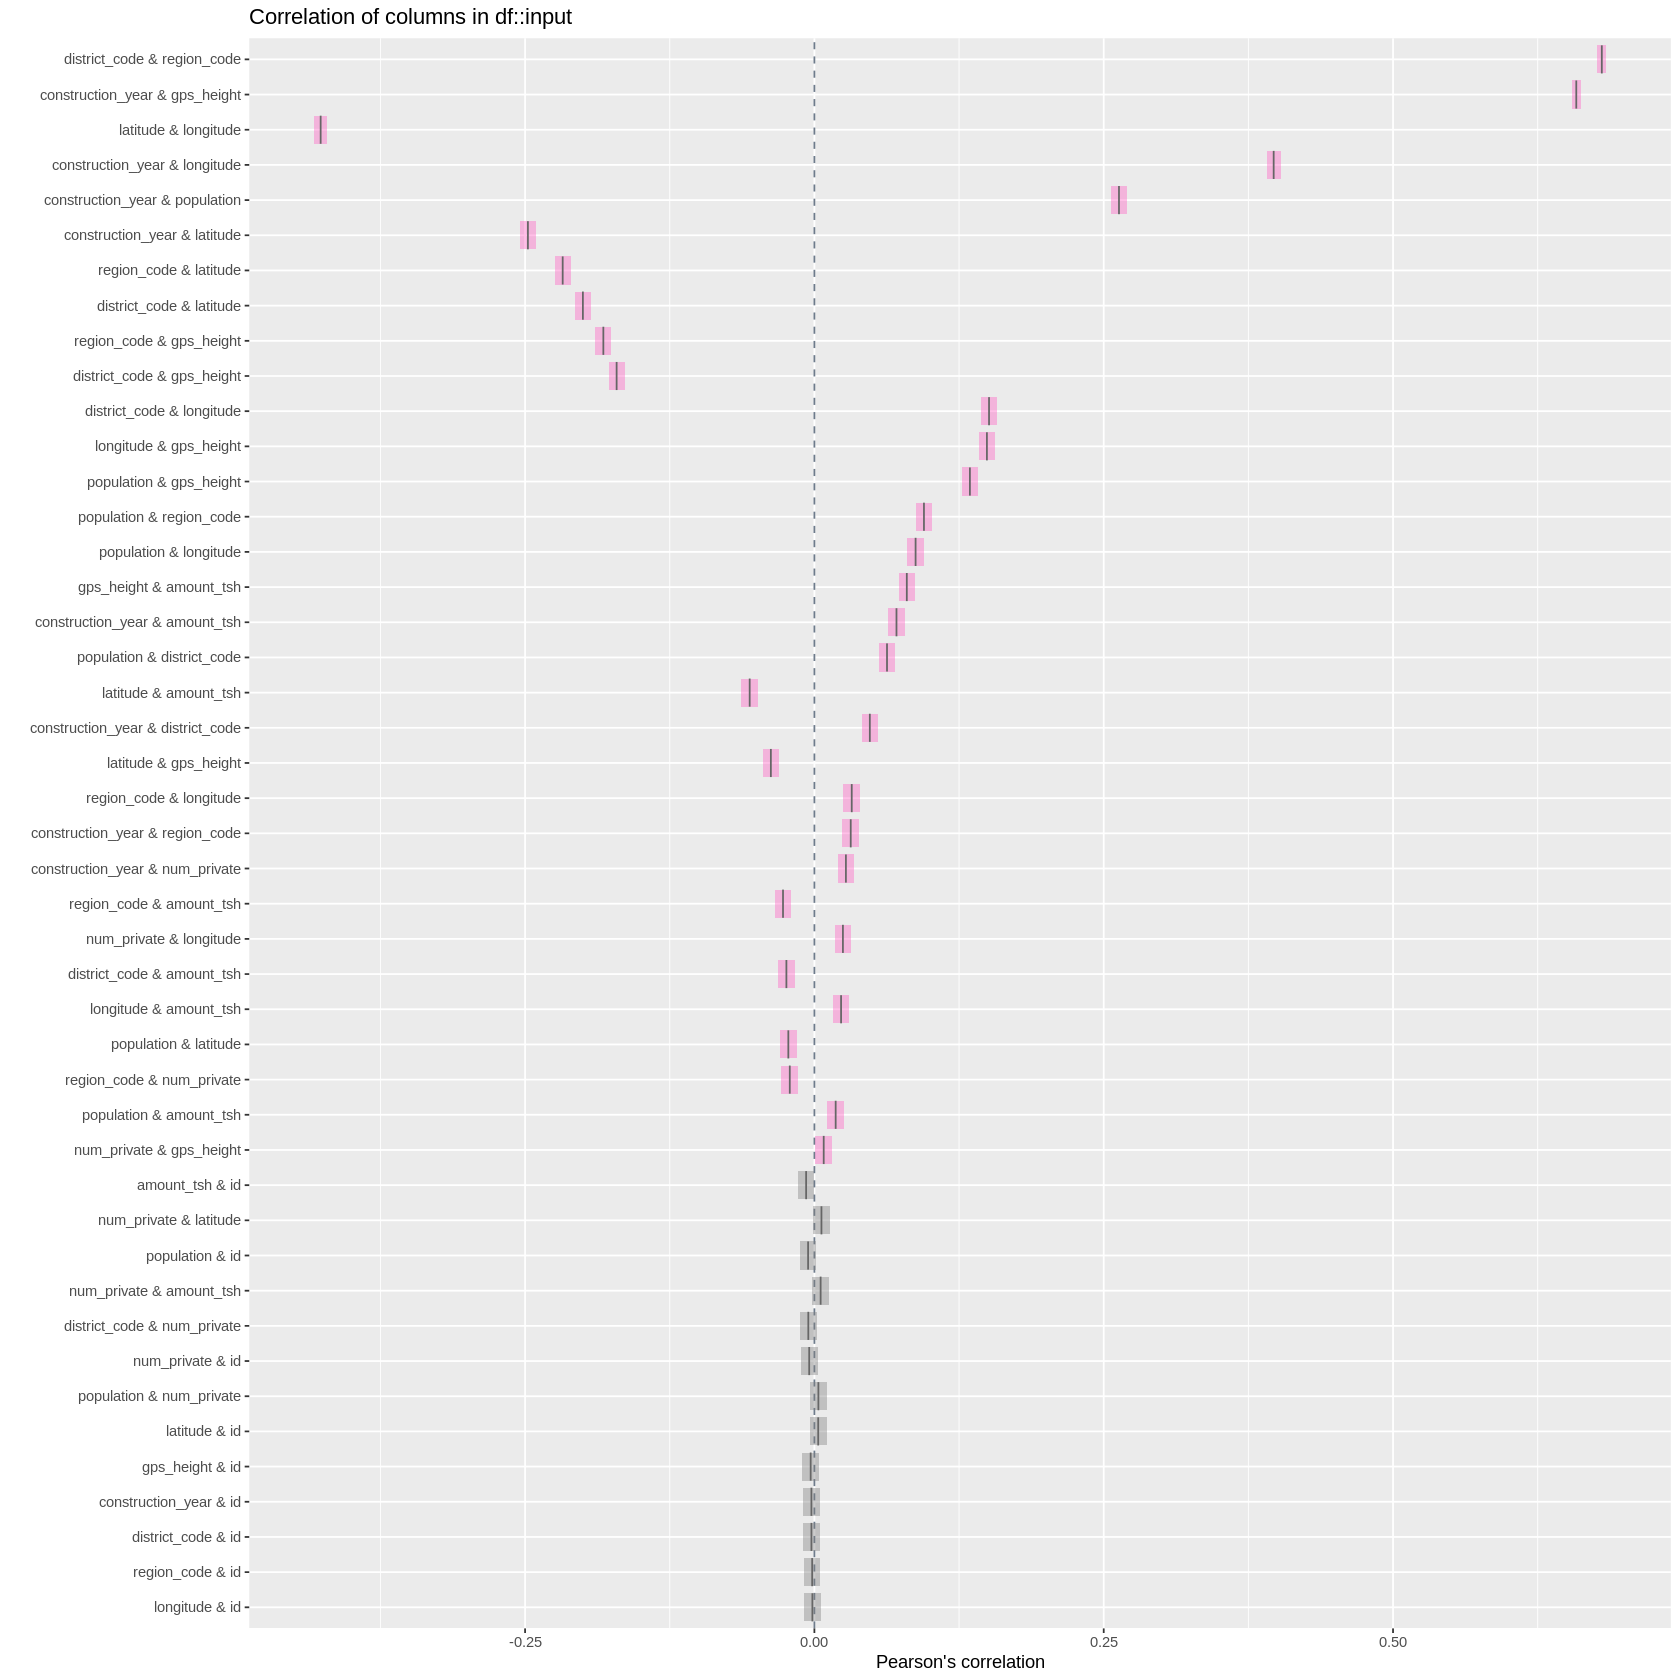

In [8]:
options(repr.plot.width=14, repr.plot.height=14)

# Correlaciones entre variables numericas
x <- inspect_cor(input)
show_plot(x)



```
El grafico anterior nos muestra la correlacion entre las distintas variables
del dataset. Estan ordenadas en orden de valor absoluto(independientemente de 
si son negativas o positivas).
lo qu salta a la vista, son las correlacciones entre num_private, id con el
resto de las variables(nulas), lo cual es normal ya que a priori no tienen nada 
que ver entre ellas. Seran las primeras en ser eliminadas.

Luego estan las que tienen bastente correlacion entre ellas, lo cual 
puede crear problemas de multicolinealidad.
ejemplos: 
district_code & region_code  70%,
constructio_year & gps_height 70%,
latitude & longitude 48%, 
construction_year & longitude 40%,
construction_year & latitude 40%,
region_code & latitude 24%,
district_code & latitude 22%,
region_code & gps_height 20%,
district_code & gps_height 18%.

```



###Variable Objetivo: status_group

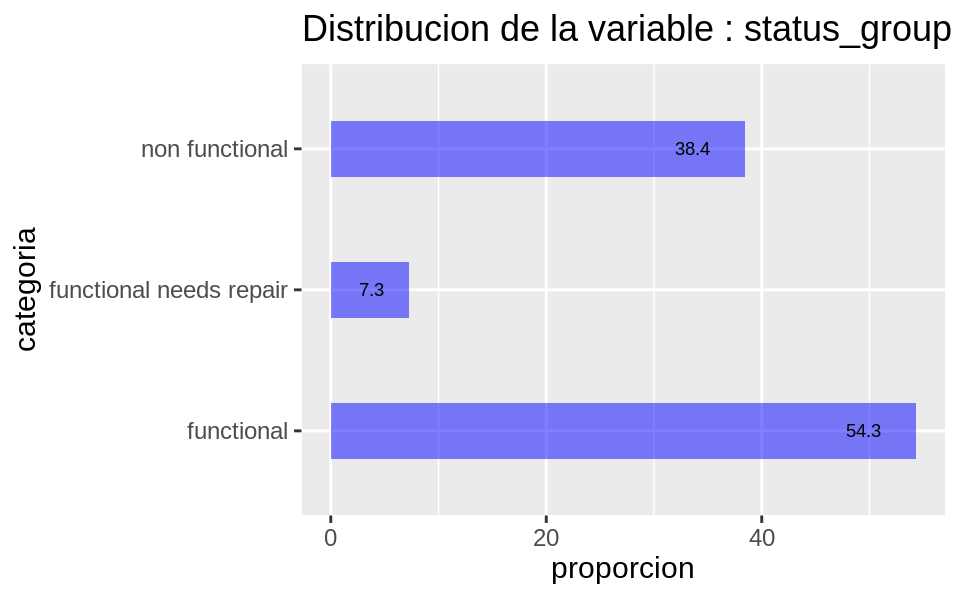

In [ ]:
options(repr.plot.width=8, repr.plot.height=5)

#calculamos frecuencias de las categorias en la variable objetivo
target_freq <- questionr::freq(input$status_group[input$status_group != 'tst'],sort = "dec")
# Barplot
ggplot(target_freq, aes(x=rownames(target_freq) ,y=`val%`)) + 
  geom_bar(stat = "identity",fill="blue",alpha = .5, width=0.4)+
    labs(
    x = "categoria",
    y = "proporcion"
  ) +
  ggtitle("Distribucion de la variable : status_group") +
  geom_text(aes(label = `%`), hjust = 2)+
  coord_flip()+
  theme_gray(base_size = 18)



```
Nuestra variable objetivo tiene una distribucion desbalanceada
Functional needs repair es muy minoritaria, lo que provocaria que al 
modelo le cueste reconocerla cuando se entrena.

Al ser un problema de clasificacion, tomaremos la proporcion de la clase 
de mayor frecencia: 'functional' como nuestro valor de base para un modelo inicial. 

```



In [9]:
# numero de niveles por variable, y proporcion de la categoria mas presente.
inspect_nivel <- catg_inpct[,c(1:4)]
head(inspect_nivel[order(inspect_nivel$common_pcnt,decreasing = T),],10)

col_name,cnt,common,common_pcnt
<chr>,<int>,<chr>,<dbl>
recorded_by,1,GeoData Consultants Ltd,100.00000
management_group,5,user-group,88.26667
public_meeting,3,TRUE,85.85724
quality_group,6,good,85.52862
water_quality,8,soft,85.52862
source_class,3,groundwater,77.15286
management,12,vwc,68.18047
permit,3,TRUE,65.46263
scheme_management,13,VWC,61.84108




```
En la anterior tabla, observamos que hay variables categricas, cuya 
categoria predominante ocupa hasta el 100% de las observaciones 
(recorded_by). Sin embargo tambien hay otras variables con valores tambien 
muy altos 88%, o muy bajos <1%.
En el caso de las ultimas, se llama alta cardinalidad. Estos dos casos, 
suelen aportar poco al modelo predictivo, y añadirles una complejidad 
innecesaria.
Por ello crearemos dos umbrales por arriba y por abajo, a partir de los 
cuales no tendremos en cuenta dichas variables.
```










In [ ]:
# En esta celda, guardaremos en lista las variables cuya categoria mayoritaria 
# supera un umbral establecido. 
#umbral_arriba = 85
#tomamos los nombres de las columnas que no responden al umbral
#df_arr = list(cat_dec[cat_dec$common_pcnt > umbral_arriba,'col_name'])
#df_arr

### Recorded_by 

In [45]:
#como tiene solo una categoria vamos a eliminar recorded_by
input$recorded_by = NULL

### NA's

In [11]:
#veamos los valores nulos por variable en orden descendente
valores_nulos <- inspect_na(input)
head(valores_nulos,5)

col_name,cnt,pcnt
<chr>,<int>,<dbl>
public_meeting,4155,5.595960
permit,3793,5.108418
id,0,0.000000
amount_tsh,0,0.000000
date_recorded,0,0.000000


```
Inspect_na solo detecta automaticamente valores nulos en public_meeting y permit.
A continuacion, le indicamos los posibles valores nulos que pueden tomar 
las observaciones categoricas.
Convertiremos para esto, las variables de tipo character en Factore
(categoricas convertidas a numeros). 
```

In [46]:
# obtenemos los nombres de columnas categoricas
input_cat <- input %>%select_if(is.character) 
#cambiamos cualquier valor que pueden tomar los nulos, y lo cambiamso a na.(como otra categoria)
input_cat[input_cat==""|input_cat=="-"|input_cat=="_"|input_cat==" "|
          input_cat=="none"|input_cat=="None"|input_cat=="unknown"|
          input_cat=="other"|input_cat=="0"] = 'na'

In [47]:
# reempazamos las categoricas sin nulos, por las que han sido cambiadas
input[,colnames(input_cat)] = NULL
input = cbind(input,input_cat)



```
La tabla anterior refuerza la idea de la presencia de duplicados:
varias columnas en duplicado o casi duplicado(variacion minima en el 
valor de las categorias). Esto se deduce de la proporcion y numeros absolutos 
de valores nulos exactamente iguales (hasta el octavo decimal) que comparten 
dos o hasta 3 columnas distintas.
```



###plot cat 





```
Veamos como se comportan las variables categoricas con la variable objetivo.
Hemos seleccionado las variables categoricas con 
un numero reducido de categorias.
Las hemos agrupado por nombre, ya que varias se parecen.
```



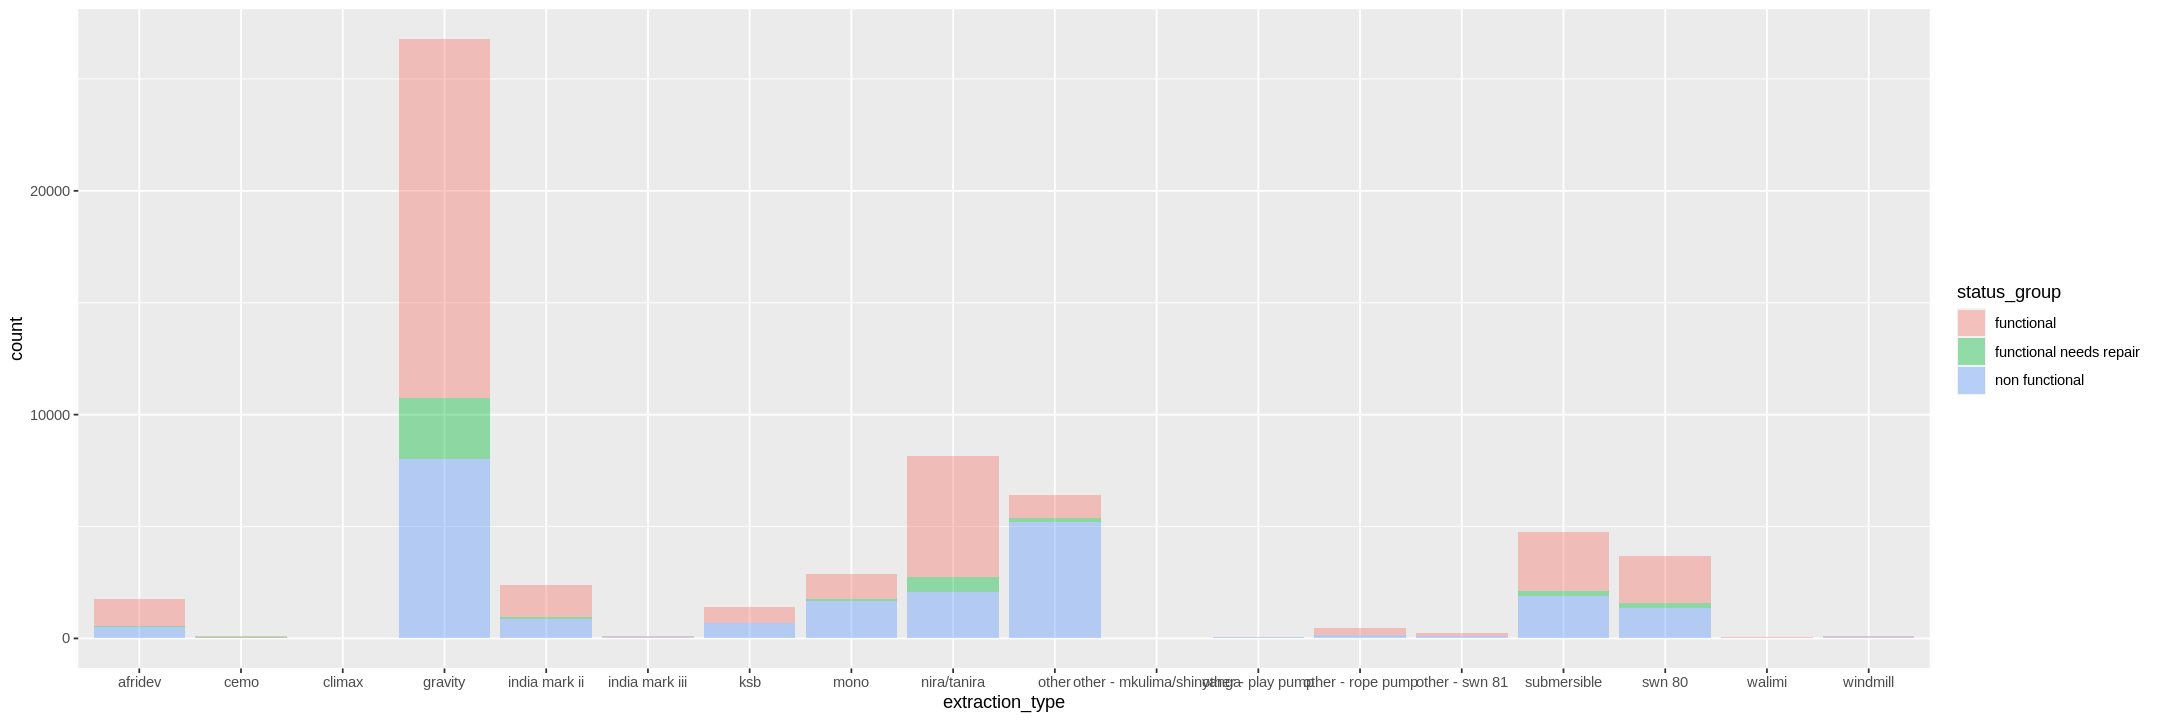

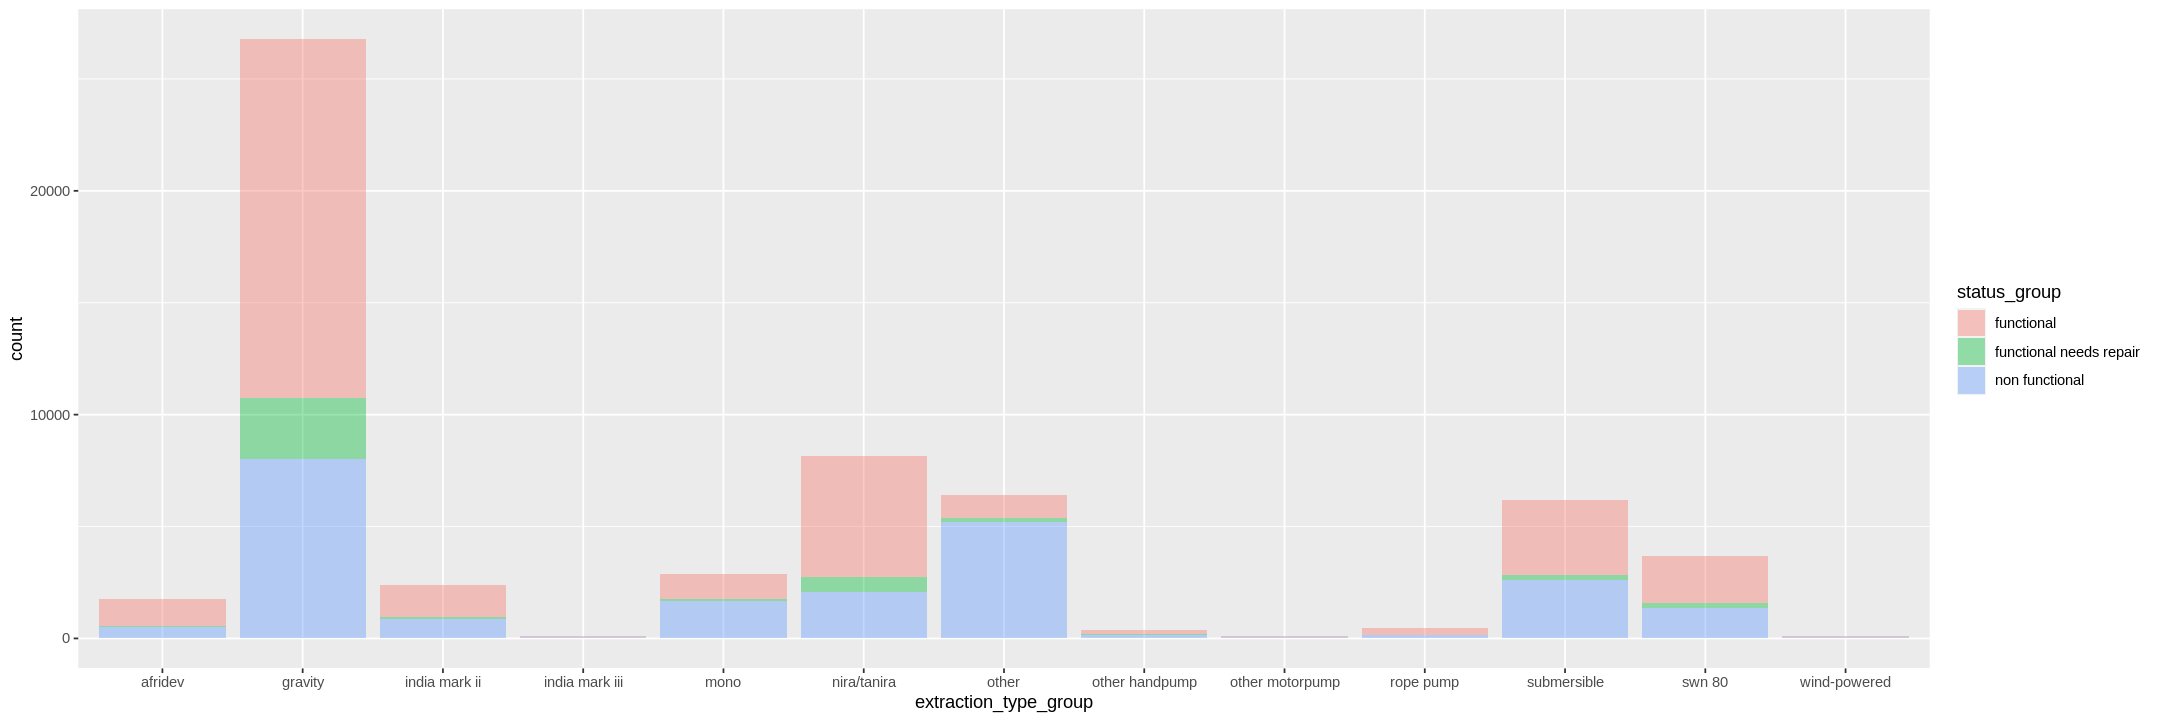

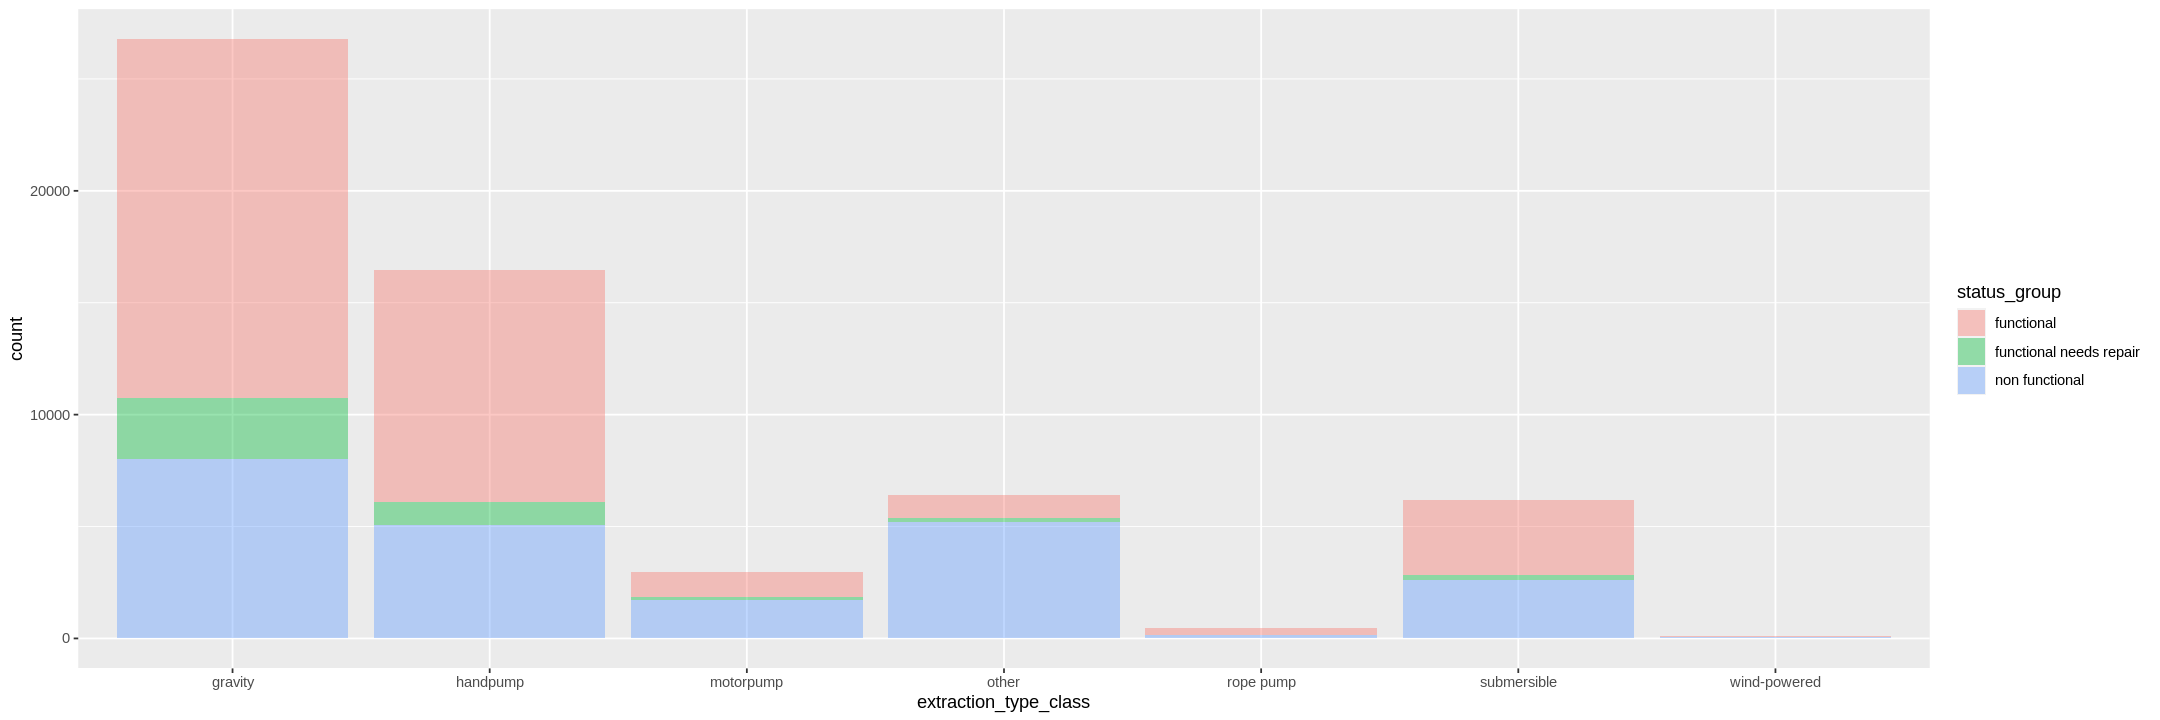

In [ ]:
options(repr.plot.width=18, repr.plot.height=6)

ggplot(DF_def, aes(x=extraction_type,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=extraction_type_group,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=extraction_type_class,fill=status_group)) + 
        geom_bar(alpha=0.4)
# el tipo de extraccion 'gravity', que es el predominante en las tres,tiene una proporcion
# de funcionales mayor que el resto de tipos. Lo mismo se puede decir para 'tanira' en fig2 y 3.
# 'other' por otro lado concentra mas proporcion de no funcionales.

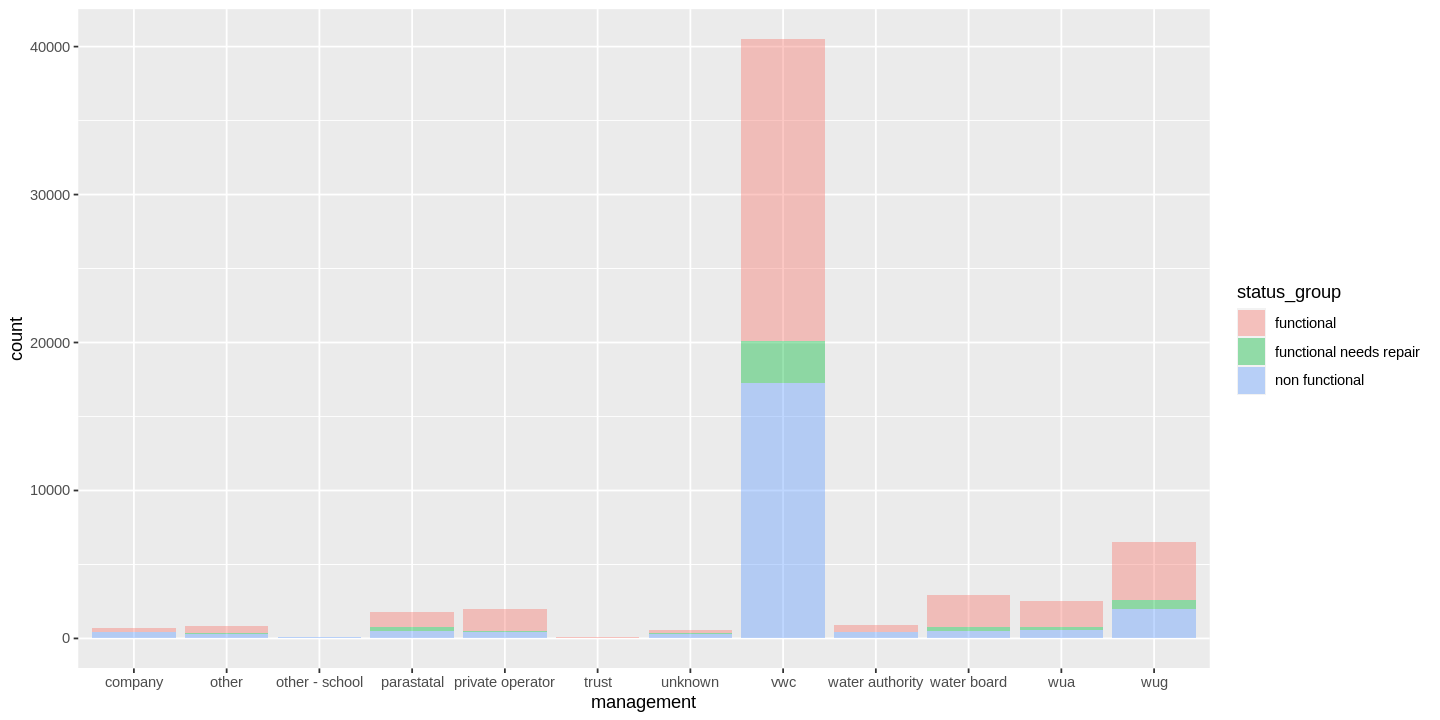

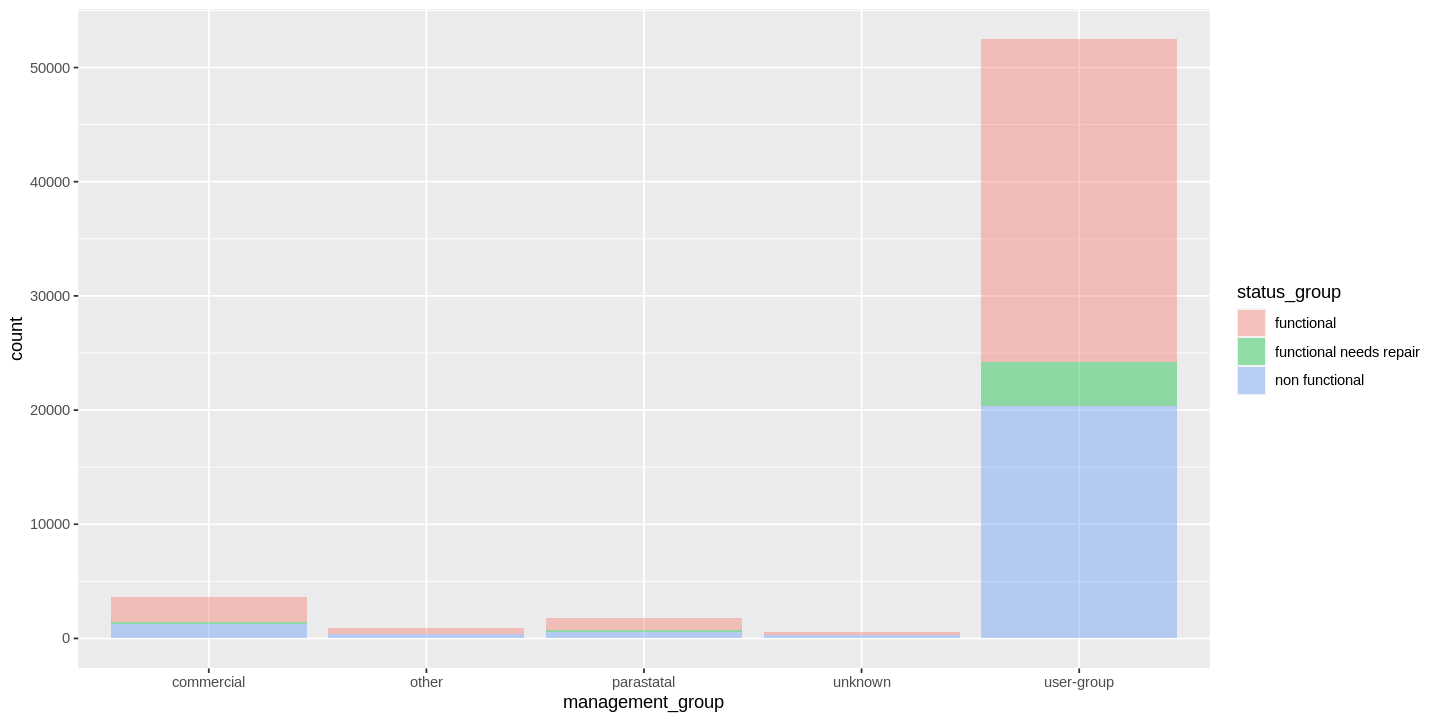

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
ggplot(DF_def, aes(x=management,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=management_group,fill=status_group)) + 
        geom_bar(alpha=0.4)
# vwc, la categoria predominante en management, presenta una mayor presencia de 
# functional aunque la diferencia no es muy grande.
# algo similar ocurre conn user-group en management group.

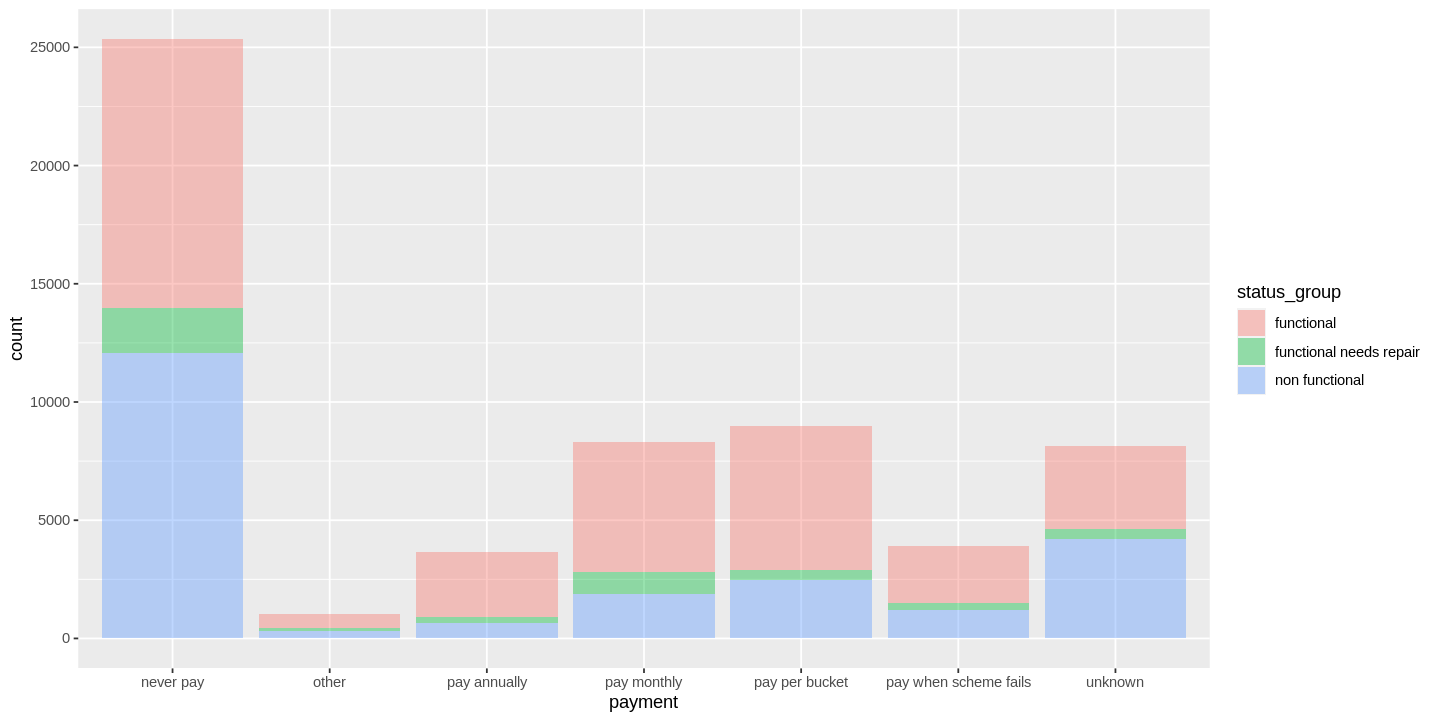

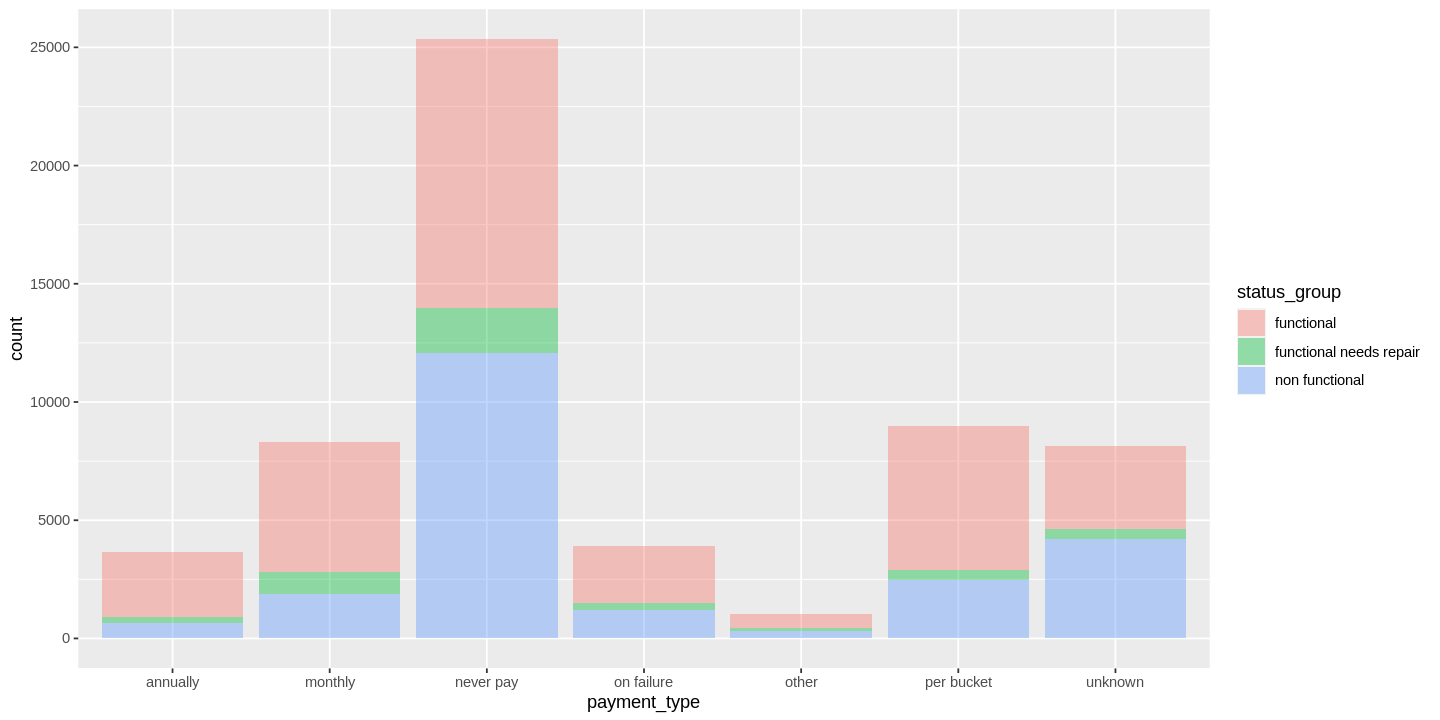

In [ ]:
ggplot(DF_def, aes(x=payment,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=payment_type,fill=status_group)) + 
    geom_bar(alpha=0.4)
# payment y payment type no presentan proporciones dispares de status_group
# que se puedan resaltar.

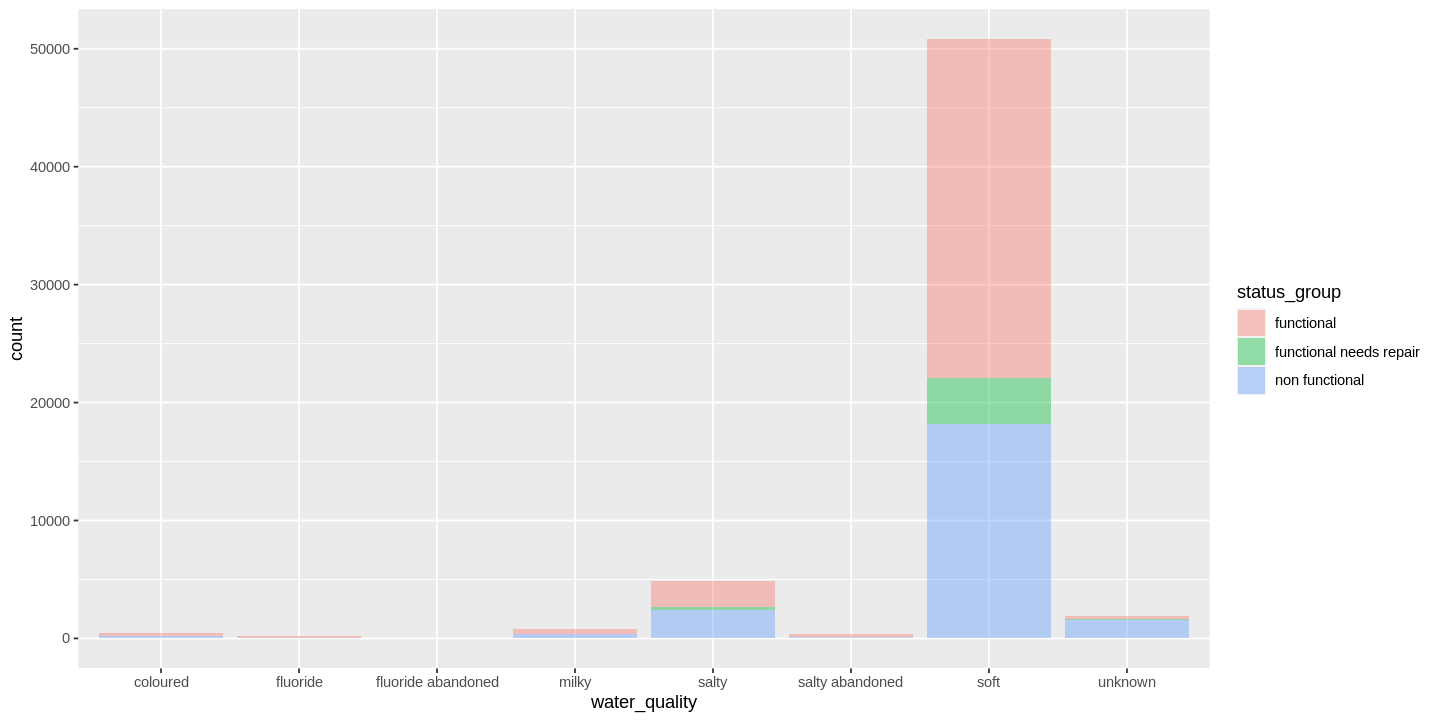

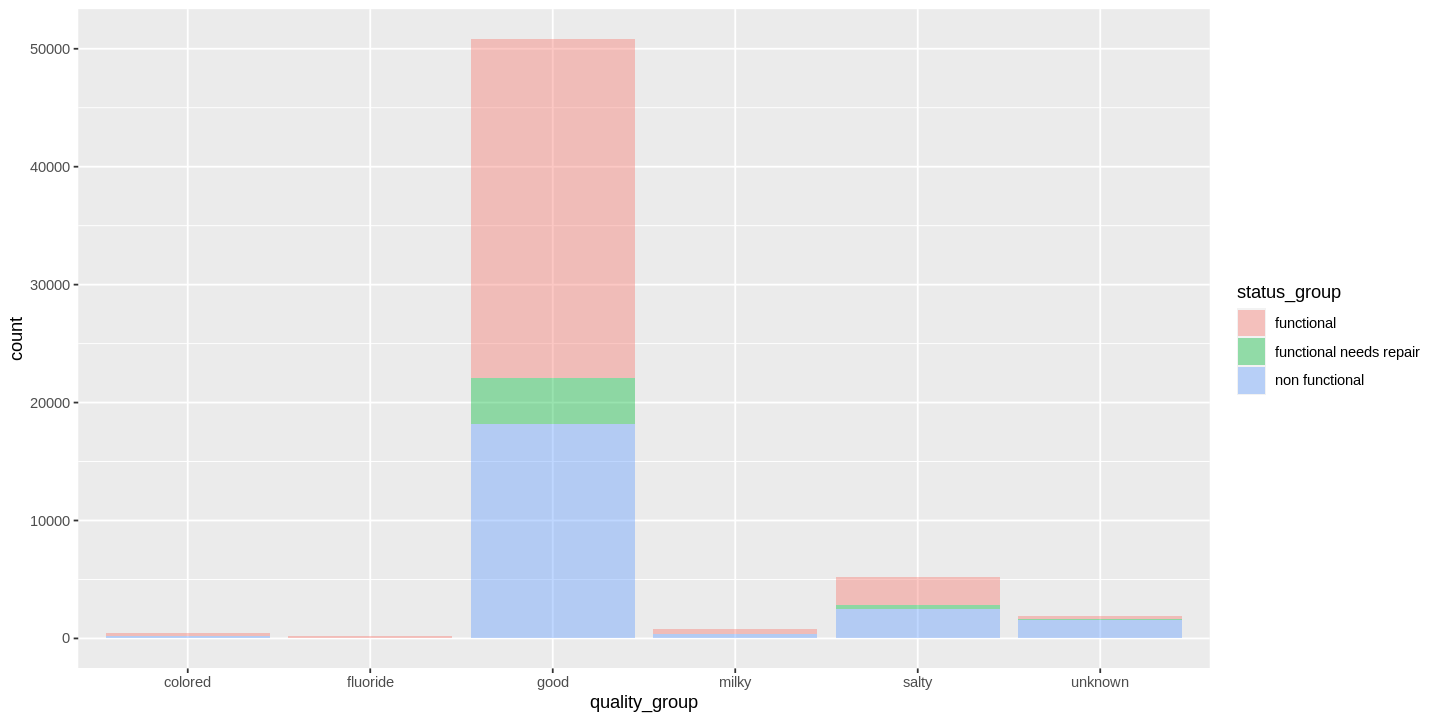

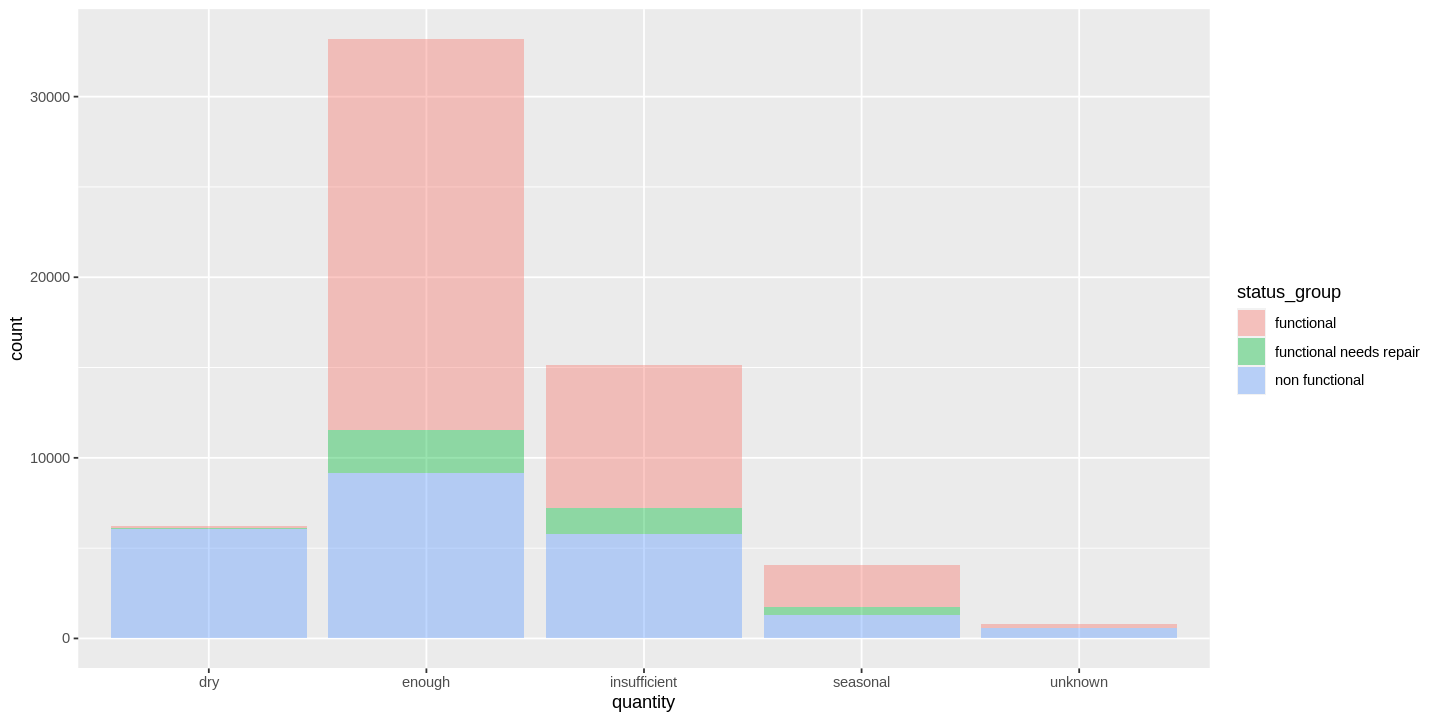

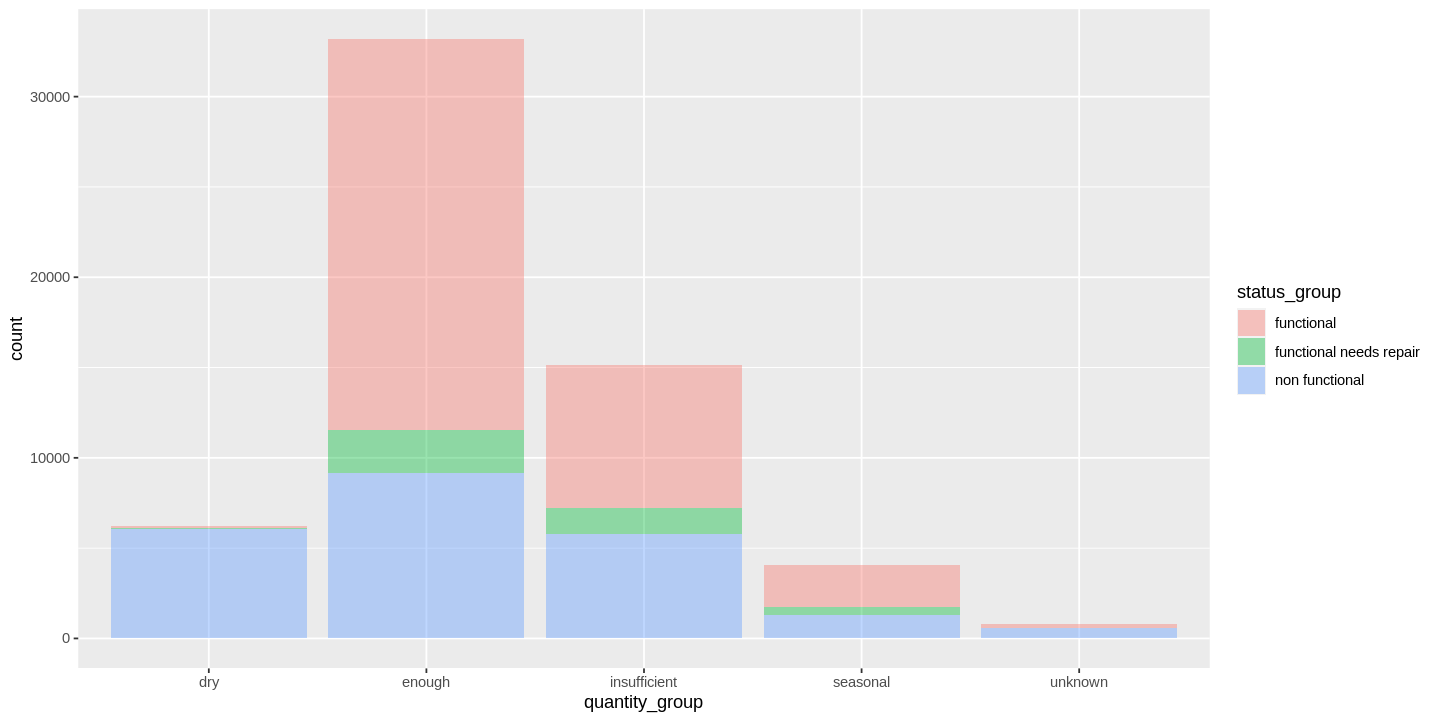

In [ ]:
ggplot(DF_def, aes(x=water_quality,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=quality_group,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=quantity,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=quantity_group,fill=status_group)) + 
    geom_bar(alpha=0.4)
# soft en water_quality presenta mayor porporcion de functional que el resto de 
# las categorias, y lo mismo ocurre con good en quality group.
# eso se acentua en quantity y quantity_group, ya que 'enough', predominante en  
# las dos, tiene todavia mas pozos funciones en proporcion que el resto de categorias.

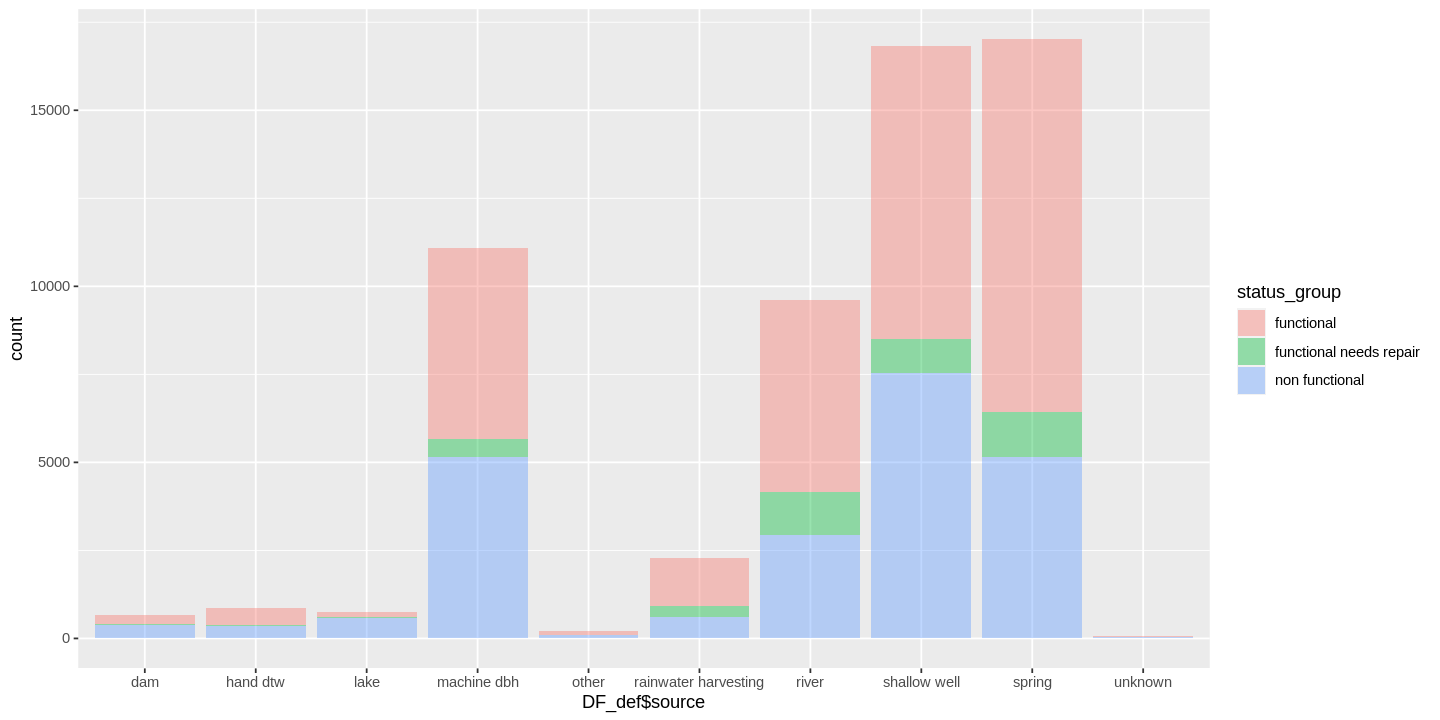

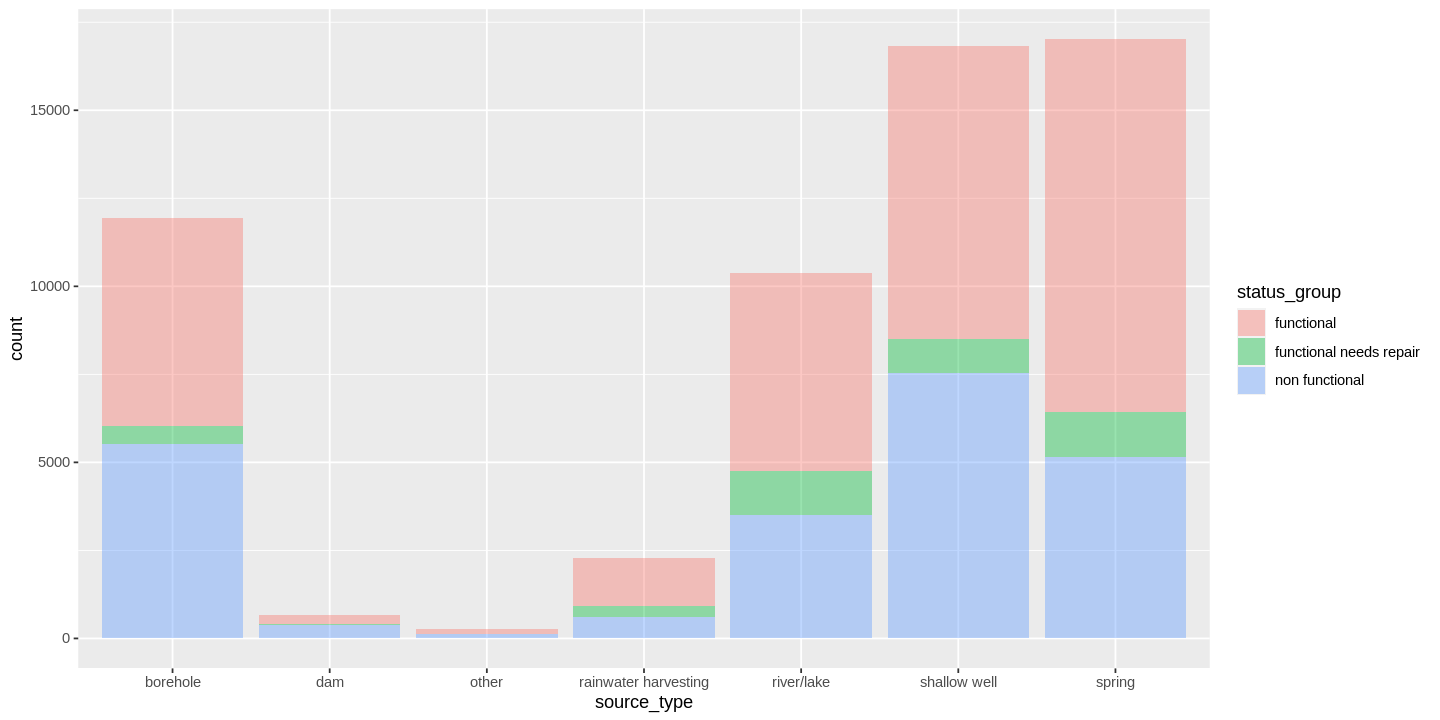

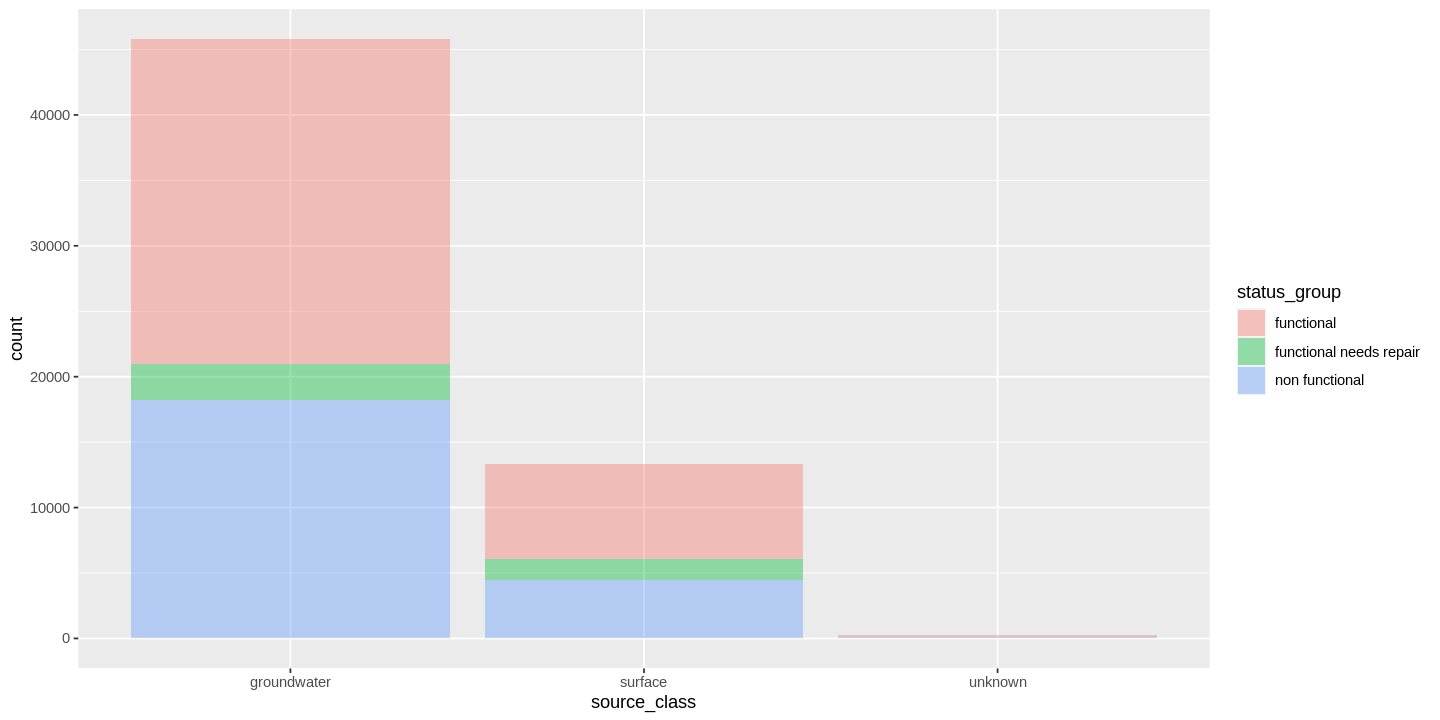

In [ ]:
ggplot(DF_def, aes(x=DF_def$source,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=source_type,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=source_class,fill=status_group)) + 
        geom_bar(alpha=0.4)
# spring tiene mayor porporcion de functional que shallow well tanto en 
# source como en scource type.

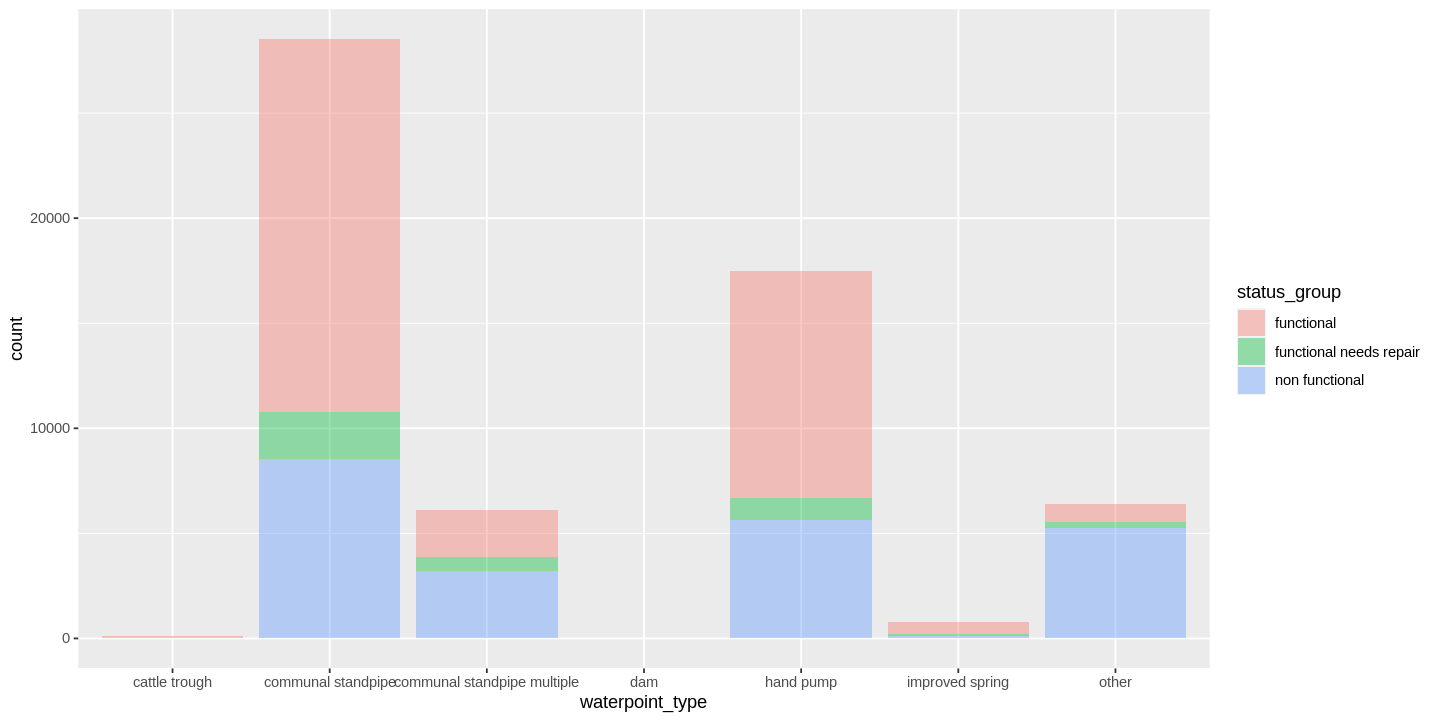

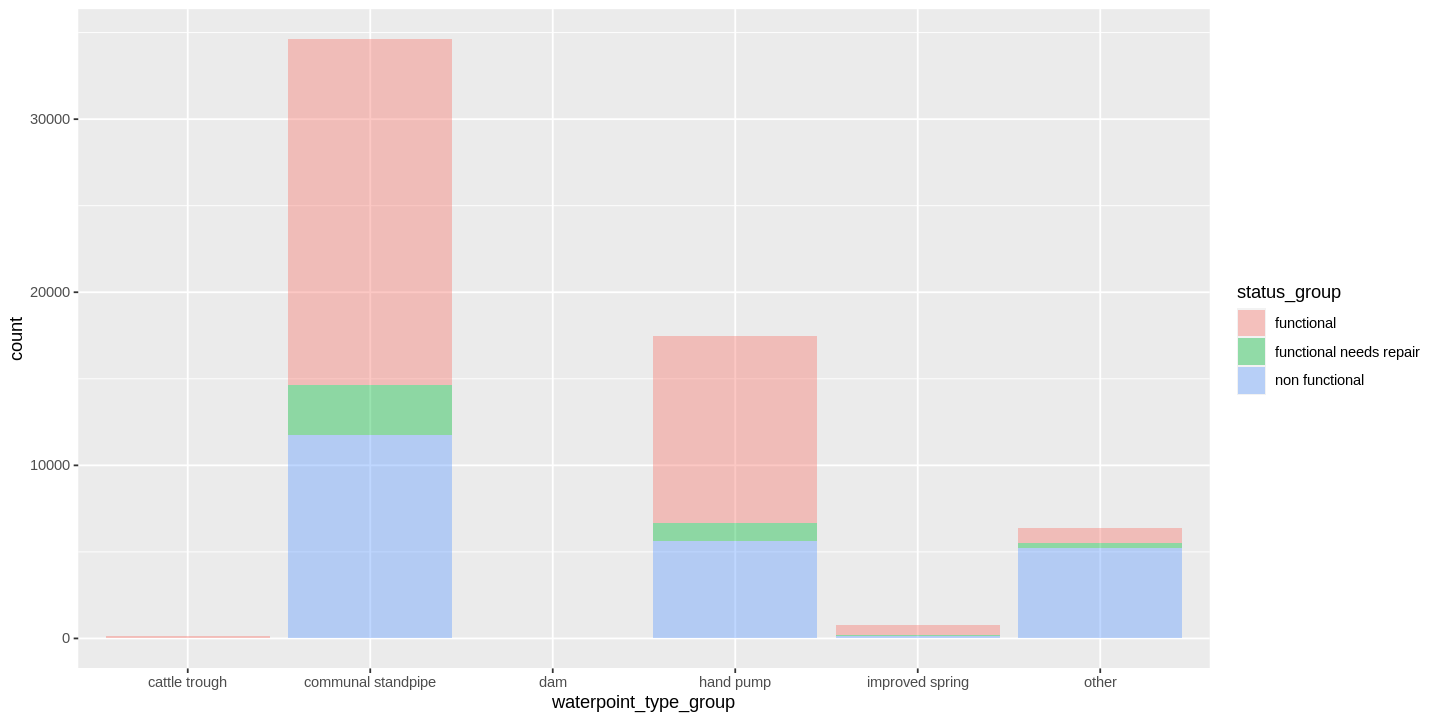

In [ ]:
ggplot(DF_def, aes(x=waterpoint_type,fill=status_group)) + 
        geom_bar(alpha=0.4)
ggplot(DF_def, aes(x=waterpoint_type_group,fill=status_group)) + 
        geom_bar(alpha=0.4)
# aqui communal, que imagino que agrupa mas gente, tiene una importante 
# concentracion de funcionales y lo mismo ocurre con hand pump  tanto 
# en watepoint_type como en waterpoint_type_group.

### VCramer relacion Variable/Objetivo

In [17]:
# Calcula el V de Cramer
Vcramer<-function(v,target){
  if (is.numeric(v)){
    v<-cut(v,5)
  }
  if (is.numeric(target)){
    target<-cut(target,5)
  }
  cramer.v(table(v,target))
}

# Gráfico con el V de cramer de todas las variables input para saber su importancia
graficoVcramer<-function(matriz, target){
  salidaVcramer<-sapply(matriz,function(x) Vcramer(x,target))
  par(mar=c(15,4,4,4))
  barplot(sort(salidaVcramer,decreasing =T),las=2,ylim=c(0,1), cex.names = 1.5)

}

In [18]:
datos = input %>% filter(status_group != 'tst')
datos  = input[,-'status_group']#
target = input$status_group

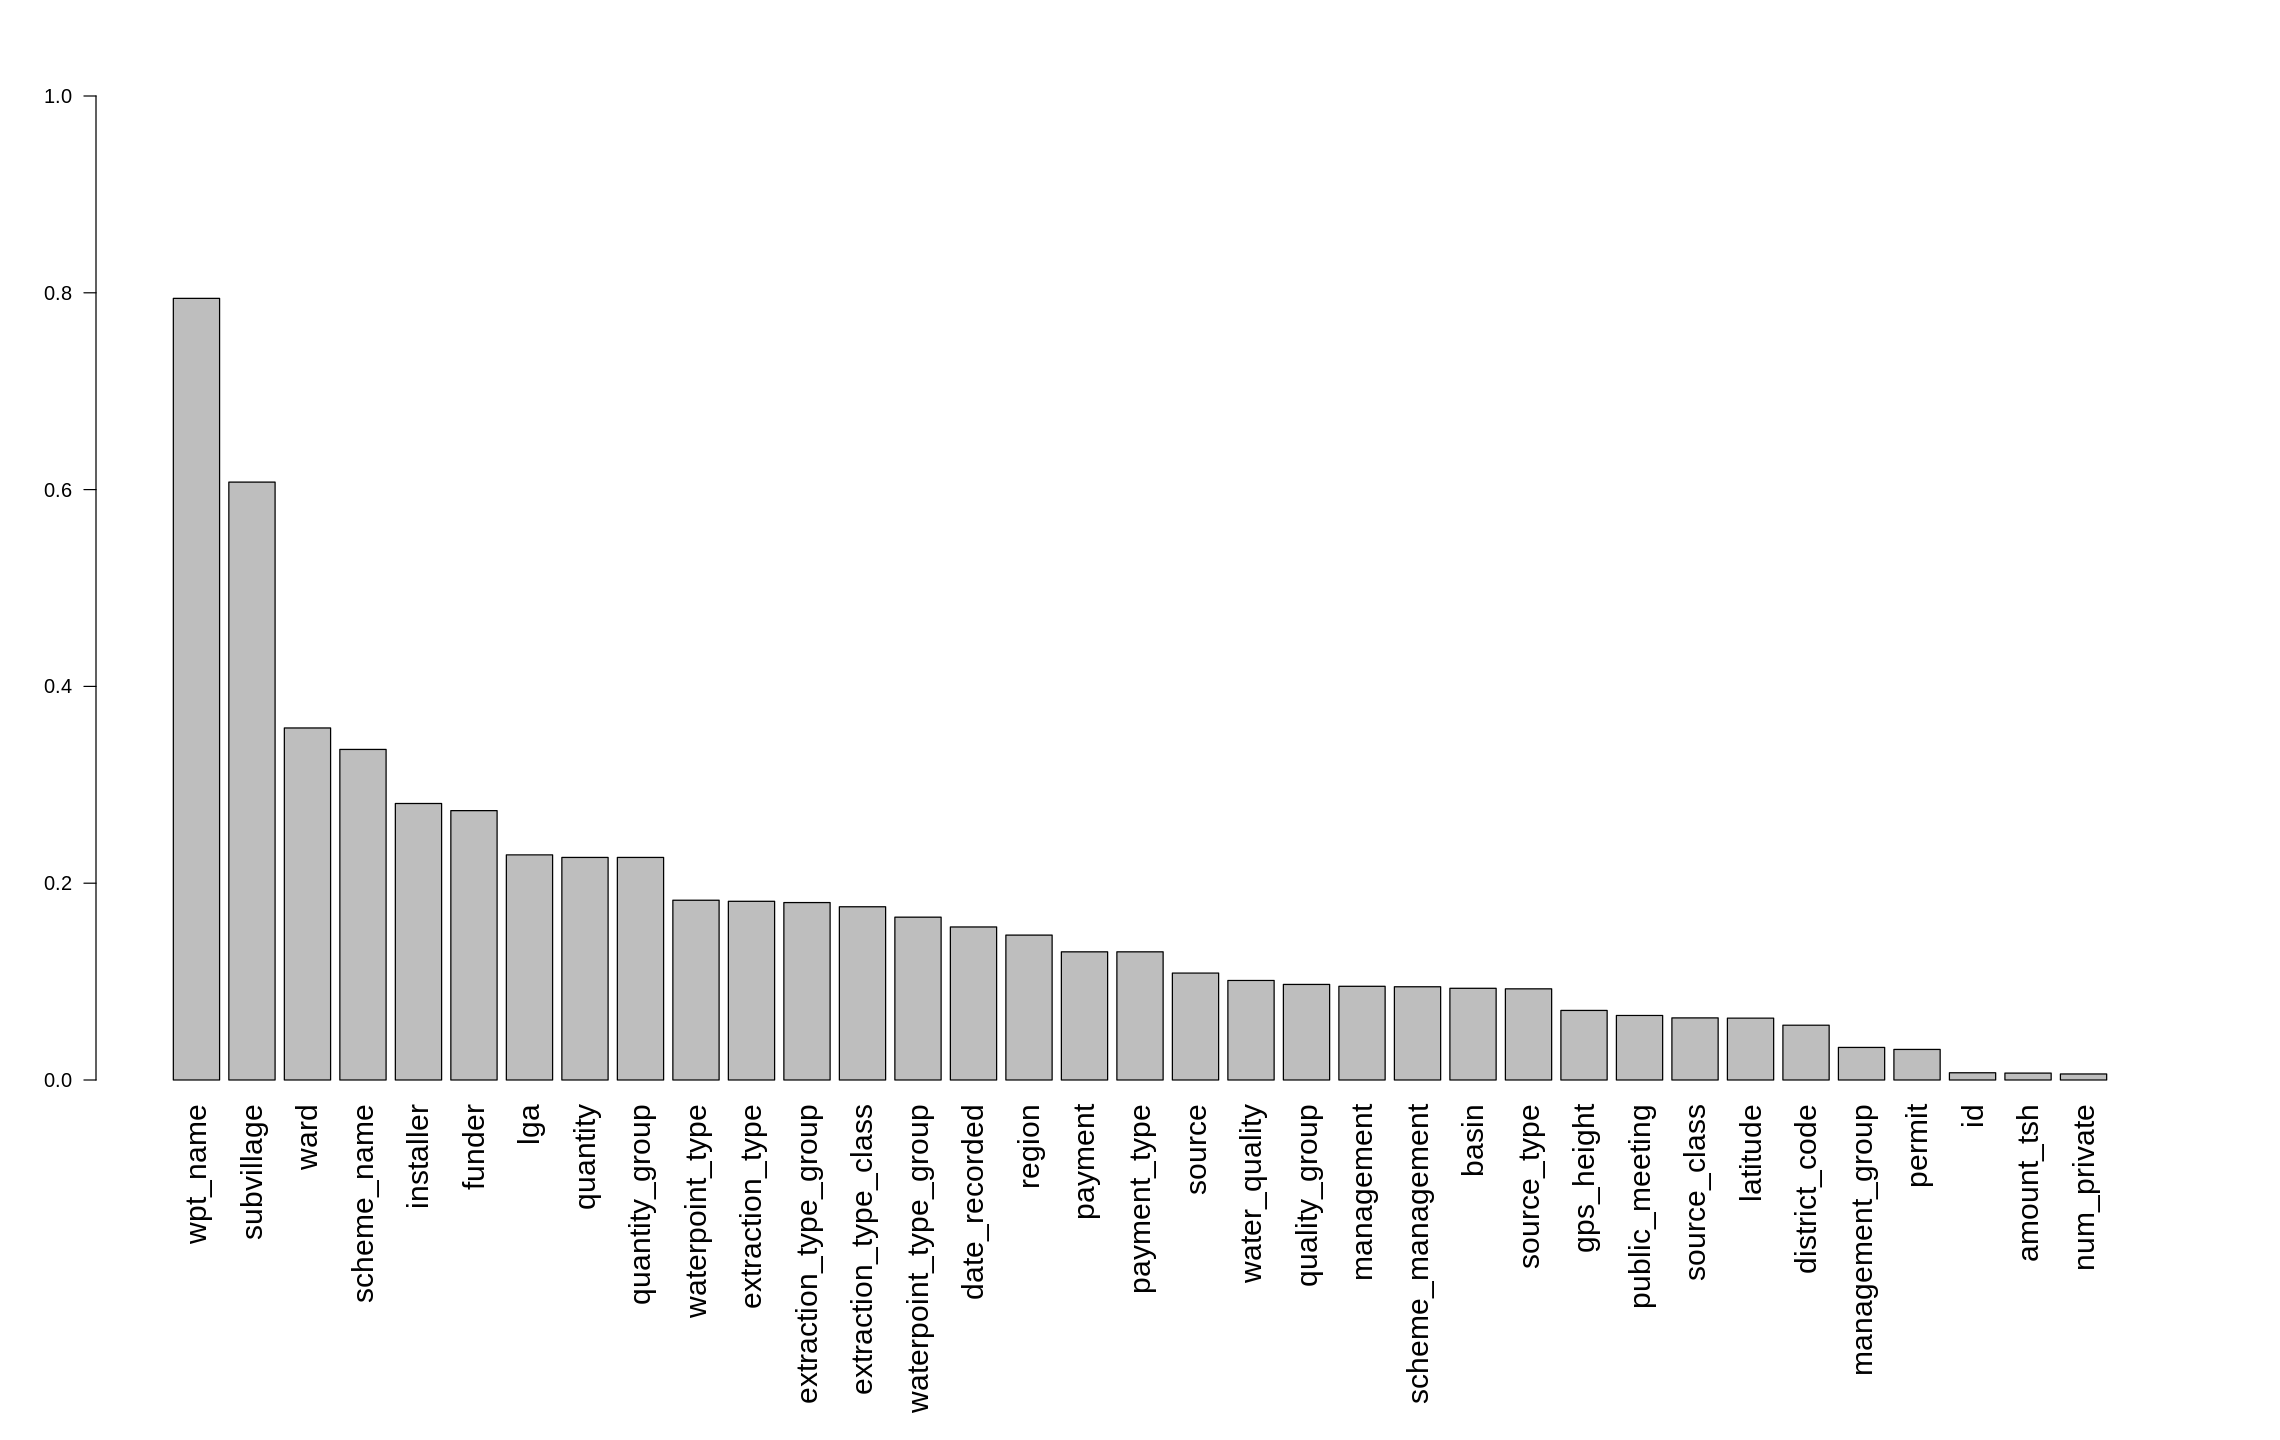

In [19]:
options(repr.plot.width=19, repr.plot.height=12,warn = -1)
graficoVcramer(datos,input$status_group)

Este grafico, representa visualmente el valor de V de cramer. En él se mide la forma en que están asociados dos campos categóricos, en este caso las variables categoricas del este dataset, y la variable objetivo: status_group.

Observamos aqui que las variables que presentan proporciones de nulos identicos , comparten tambien una correlacion identica con la variable objetivo.
Los enumeramos a continuacion:

payment \\
payment_type \\
 \\
extraction_type  \\	
extraction_type_group \\	
extraction_type_class \\
 \\
waterpoint_type \\
waterpoint_type_group \\	
 \\

water_quality  \\
quality_group  \\
\\

quantity \\
quantity_group \\
 \\
source \\
source_type \\
source_class  \\


In [ ]:
# relacion en payment:
Vcramer(input$payment,input$payment_type)
# relacion extraction:
Vcramer(input$extraction_type,input$extraction_type_class)
Vcramer(input$extraction_type,input$extraction_type_group)
#relacion en waterpoint:
Vcramer(input$waterpoint_type,input$waterpoint_type_group)
#relacion en water_quality:
Vcramer(input$quality_group,input$water_quality)
#relacion en quantity:
Vcramer(input$quantity,input$quantity_group)
#relacion en source:
Vcramer(input$source,input$source_class)
Vcramer(input$source,input$source_type)

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1



```
Los resultados anteriores son calculos de la v de cramer de variables
que sospechamos que son duplicados. Vcramer = 1 significa que la asociacion es
perfecta. lo que nos indica que en efecto son duplicados. En una futura celda 
prescinidremos de los duplicados.
```



###relacion con la target

In [20]:
# relacion de las variables categoricas con la variable objetivo
# a mayor Vcramer mayor relacion de 'correlacion'
salidaVcramer<-sort(sapply(datos,function(x) Vcramer(x,target)),dec=T)
head(as.data.frame(salidaVcramer),10)#los primeros 5

,salidaVcramer
,<dbl>
wpt_name,0.7943249
subvillage,0.6075997
ward,0.3577751
scheme_name,0.3359558
installer,0.2809873
funder,0.2737429
lga,0.2287980
quantity,0.2261659
quantity_group,0.2261659


In [21]:
options(warn = -1)

vcram1 = Vcramer(DF$management,DF$management_group)
vcram2 = Vcramer(DF$management,DF$scheme_management)
sprintf("La v de Cramer entre management y management_group es de %s", vcram1)
sprintf("La v de Cramer entre management y scheme_management es de %s", round(vcram2,2))

[1] "La v de Cramer entre management y management_group es de 1"

[1] "La v de Cramer entre management y scheme_management es de 0.75"

In [48]:
# lista de variables a quitar porque estan duplicadas.
# se podran tener en cuenta en el futuro, por que tienen distribucion de categorias distintas.
lista_quitar <- c('payment_type','extraction_type_class','extraction_type_group','waterpoint_type_group',
                  'quality_group','management_group','quantity_group','source_class','source_type')
input = select(input, - all_of(lista_quitar))

## Variables numericas

In [23]:
# Descripcion estadistica de las var numericas
input %>% select_if(is.numeric)%>%summary()

       id          amount_tsh         gps_height       longitude    
 Min.   :    0   Min.   :     0.0   Min.   : -90.0   Min.   : 0.00  
 1st Qu.:18562   1st Qu.:     0.0   1st Qu.:   0.0   1st Qu.:33.09  
 Median :37124   Median :     0.0   Median : 364.0   Median :34.91  
 Mean   :37124   Mean   :   318.7   Mean   : 665.7   Mean   :34.07  
 3rd Qu.:55687   3rd Qu.:    20.0   3rd Qu.:1317.0   3rd Qu.:37.18  
 Max.   :74249   Max.   :350000.0   Max.   :2777.0   Max.   :40.35  
    latitude        num_private         region_code    district_code   
 Min.   :-11.649   Min.   :   0.0000   Min.   : 1.00   Min.   : 0.000  
 1st Qu.: -8.526   1st Qu.:   0.0000   1st Qu.: 5.00   1st Qu.: 2.000  
 Median : -5.027   Median :   0.0000   Median :12.00   Median : 3.000  
 Mean   : -5.702   Mean   :   0.4623   Mean   :15.27   Mean   : 5.629  
 3rd Qu.: -3.325   3rd Qu.:   0.0000   3rd Qu.:17.00   3rd Qu.: 5.000  
 Max.   :  0.000   Max.   :1776.0000   Max.   :99.00   Max.   :80.000  
   population

Mas de la mitad de valores de amount_tsh son 0. \\
las coordenadas presentan zeros que no deberian. \\
gran parte de num_private son zeros ya que el valor del 3er quartil es 0. \\
los codigos administrativos region_code y district code deberian ser factores. \\
population y construction_year presentan como minimos  un quarto de   
valores = 0. \\
habria que ver como imputarlos.


### num_private

In [ ]:
#frequencia por categoria en num_private
head((questionr::freq(input$num_private,sort = "dec")),3)

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,73299,98.7,98.7
1,94,0.1,0.1
6,92,0.1,0.1


La variable num_private tiene una categira que ocupa casi 99% de las observaciones. 
Significa que su capacidad de prediccion sera muy baja. La eliminaremos tambien del Dataframe.

In [49]:
# eliminamos num_private
input$num_private = NULL

### multiGraficos

In [25]:
#funcion para organizar multiples graficos en uno
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

### amount_tsh

In [ ]:
# amount_tsh tiene un 70% de 0s.
head(questionr::freq(input$amount_tsh,sort = "dec"),3)

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,52049,70.1,70.1
500,3874,5.2,5.2
50,3103,4.2,4.2



```
En este caso, tenemos varias opciones, borrar los outliers y en ese caso
perder una cantidad importante de observaciones dependiendo del percentil 
eliminado. La segunda opcion es imputar esos outliers por la moda de la 
variable, lo que podria sesgar la muestra involuntariamente.
La ultima opcion podria ser eliminar la variable si no aporta nada al modelo.
```

In [50]:
#grafico antes de imputacion
amnt <- ggplot(input%>% filter(status_group!='tst'), aes(x=amount_tsh,fill=status_group)) + 
  geom_density(alpha=0.4)

In [51]:
# umbral para borrar ouliers 
Q <- quantile(input$amount_tsh, .95)
# reemplazar outliers por la mediana
input$amount_tsh <- replace(input$amount_tsh,input$amount_tsh > Q,median(input$amount_tsh))

In [52]:
#grafico despues de imputacion
amnt2 <- ggplot(input%>% filter(status_group !='tst'), aes(x=amount_tsh,fill=status_group)) + 
  geom_density(alpha=0.4)

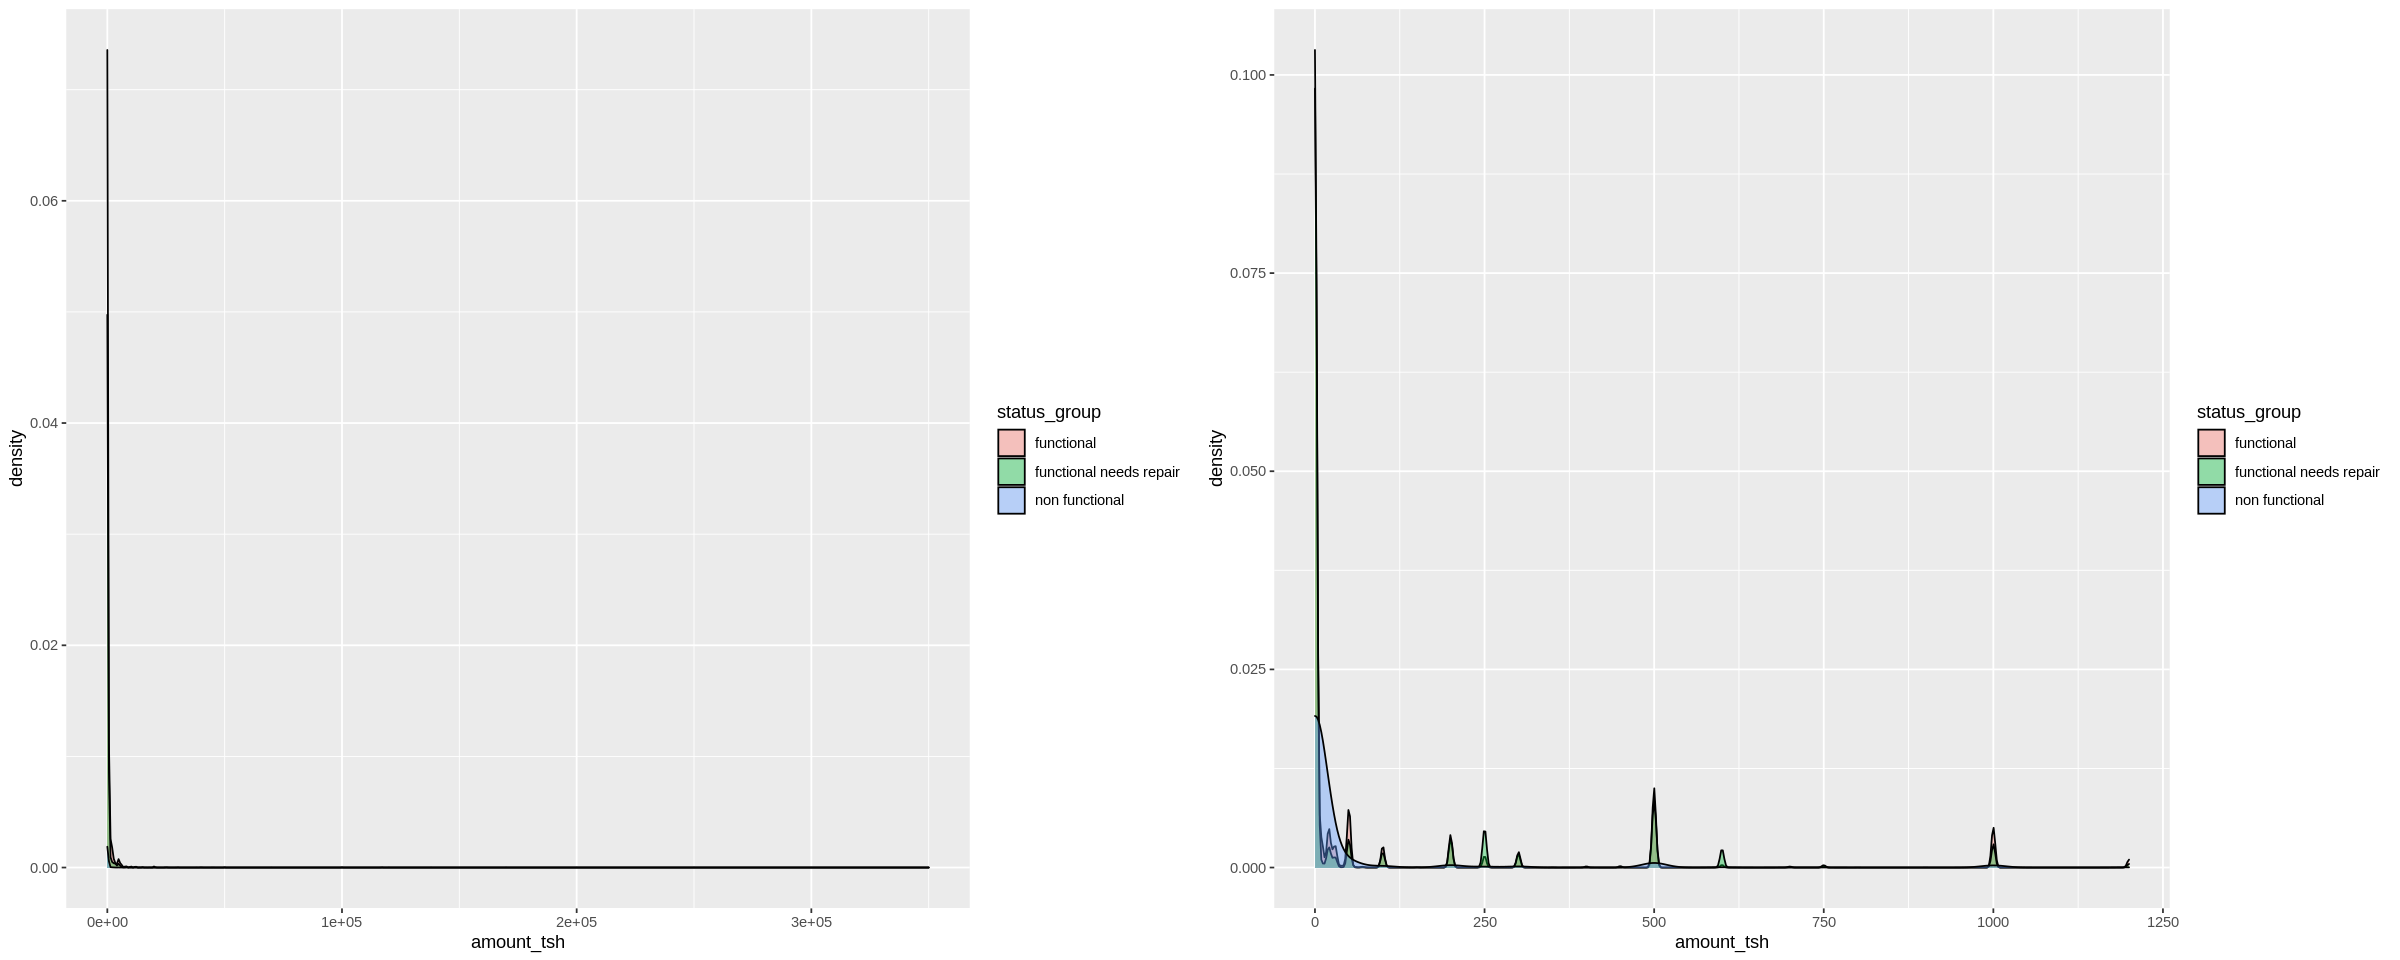

In [29]:
options(repr.plot.width=20, repr.plot.height=8)

#hacemos un grafico del cambio
multiplot(amnt,amnt2, cols = 2)

### datos geoespaciales:



```
Debido a la presencia de valores nulos en las coordenadas , imputaremos 
esos valores agrupando por distintas delimitaciones geograficas(lga, region), 
yendo de mas granular a menos.
lo que nos proporcionara mas precision,y luego reemplazar los valores nulos 
por la mediana de coordenadas(lga y region en las tres coordenadas)
```



```
Podemos ver un punto a la izquierda de la visualizacion, que son puntos de 
coordenadas (0,0) superpuestos. Estos son NA's no declarados, ya que (0,0) no 
esta en tanzania.

gps_height es mas problematico, ya que tiene muchos 0, siendo este un valor 
valido(como altitud).

tenemos dos opciones:
1_ reemplazar esos valores por la mediana del pais(con posible alto sesgo)
2_ agrupar por distrito, y reemplazar las coordenadas por las medianas de los
distritos (menos sesgo).
```



In [30]:
# frecuencia de valores antes de la imputacion
head(questionr::freq(input$longitude,sort = "dec"),3)
head(questionr::freq(input$latitude,sort = "dec"),3)
head(questionr::freq(input$gps_height,sort = "dec"),3)

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,2269,3.1,3.1
31.61952953,2,0.0,0.0
32.91986139,2,0.0,0.0


,n,%,val%
,<dbl>,<dbl>,<dbl>
-2e-08,2269,3.1,3.1
-9.2893492,2,0.0,0.0
-8.90539462,2,0.0,0.0


,n,%,val%
,<dbl>,<dbl>,<dbl>
0,25649,34.5,34.5
-16,71,0.1,0.1
-15,69,0.1,0.1


In [53]:
#creamos nuevas columnas de medianas de coordenadas por cada lga
# fusionamos estas columnas con el dataset
pp = merge (input,
            input %>%
                select(lga, longitude, latitude, gps_height)%>%
                group_by(lga)%>%
                summarize(mean_long_lga = median(longitude, na.rm = TRUE),
                          mean_lat = median(latitude, na.rm = TRUE),
                          mean_hgt = median(gps_height, na.rm = TRUE)),
            by = 'lga')

#como sigue habiendo valores nulos en gps_height, hacemos igual que en 
# proceso anterior, esta vez agrupando por region en vez de lga.
pos = merge(pp,
            input %>% 
                select(region, gps_height) %>% 
                group_by(region) %>% 
                summarize(mean_hgt_reg = median(gps_height, na.rm = TRUE)),
            by ='region')
#cambiamos los valores nulos en las coordenadas por sus medianas respectivas.
dataset <- pos %>%
               mutate(longitude = replace(pos$longitude, pos$longitude == 0, pos$mean_long_lga)) %>%
               mutate(latitude= replace(pos$latitude, pos$latitude > -0.8 , pos$mean_lat))%>% 
               mutate(gps_height = replace(pos$gps_height, pos$gps_height == 0, pos$mean_hgt)) %>%
               mutate(gps_height = replace(pos$gps_height, pos$gps_height == 0, pos$mean_hgt_reg))
#eliminamos las columnas de medianas añadidas               
input = dataset[,1:(ncol(pos)-4)]

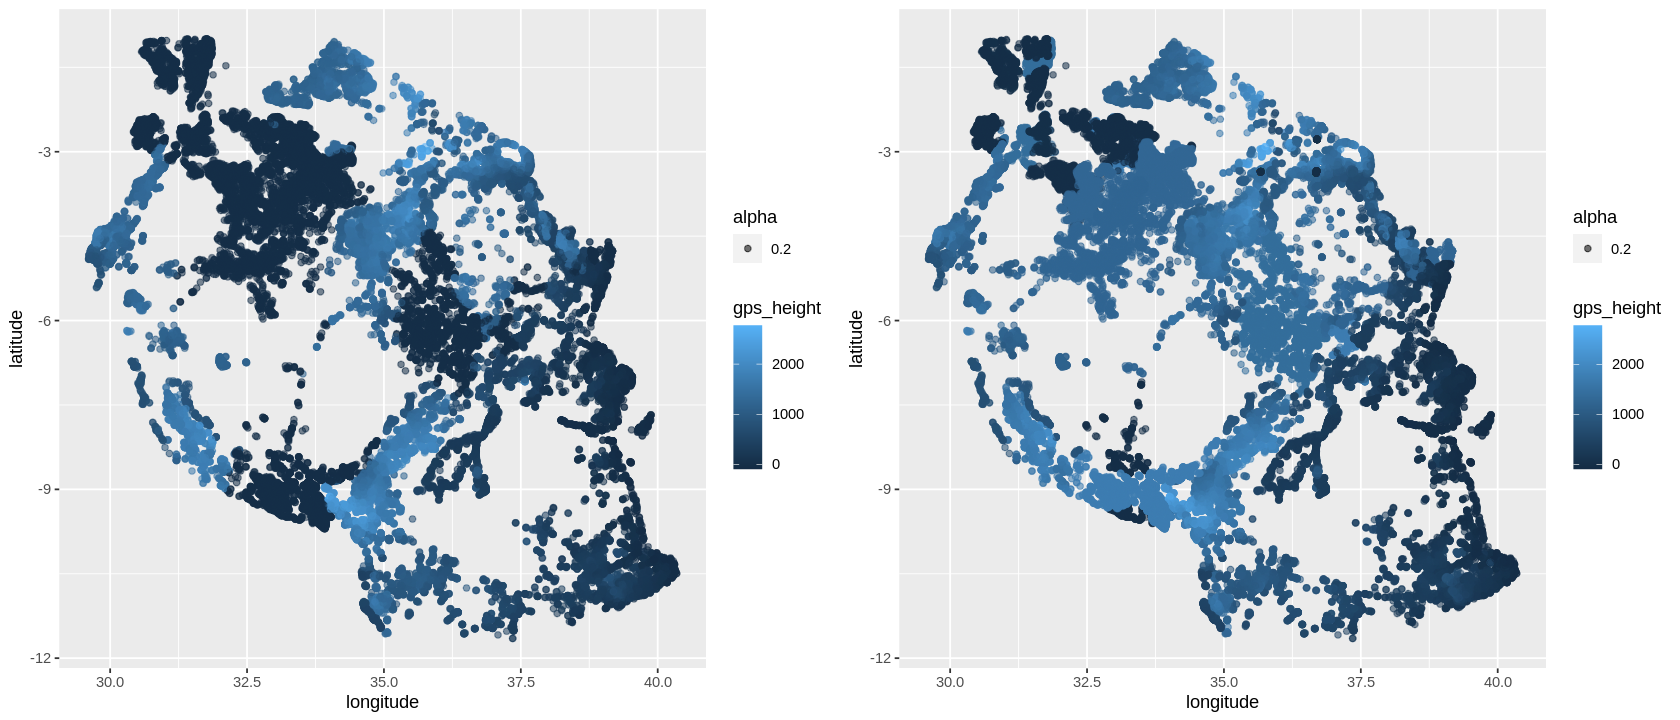

In [54]:
# mapa de gpes_height antes y despues de la imputacion
options(repr.plot.width=14, repr.plot.height=6,warn = -1)

#filtrar valores nulos en las variables originales, evitando asi la distorsion.
orig_ = filter(DF_def, DF_def$longitude > 0 & DF_def$latitude < -0.8)

plot1 = ggplot(orig_, aes(x=longitude, y=latitude, color = gps_height,alpha=0.2)) +
  geom_point()

plot2 = ggplot(input, aes(x=longitude, y=latitude, color = gps_height,alpha=0.2)) +
  geom_point()

multiplot(plot1,plot2, cols = 2)



```
Los puntos que cambian de oscuros a claros entre el primer y segundo grafico
son los valores imputados.
```



In [33]:
#frecuencia de valores despues de la imputacion
head(questionr::freq(input$longitude,sort = "dec"),3)
head(questionr::freq(input$latitude,sort = "dec"),3)
head(questionr::freq(input$gps_height,sort = "dec"),3)

,n,%,val%
,<dbl>,<dbl>,<dbl>
36.69086569,1522,2.0,2.0
35.671900145,402,0.5,0.5
36.70115167,265,0.4,0.4


,n,%,val%
,<dbl>,<dbl>,<dbl>
-3.3431163,1522,2.0,2.0
-3.354891235,402,0.5,0.5
-2.78040631,265,0.4,0.4


,n,%,val%
,<dbl>,<dbl>,<dbl>
0,6953,9.4,9.4
1720,6634,8.9,8.9
1400,4157,5.6,5.6


### fechas

In [55]:
#convertimos las variables de tipo fecha a un formato Date:
input$date_recorded <- as.Date(input$date_recorded)
input$construction_year <- year(as.Date(as.character(input$construction_year), format = "%Y"))

####Construction_year

In [35]:
head(questionr::freq(input$construction_year,sort = "dec"),3)#35%  de 0

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,25969,35.0,35.0
2010,3314,4.5,4.5
2008,3243,4.4,4.4


In [56]:
yr_impt = merge (input,
            input %>%
                select(construction_year,basin)%>%
                group_by(basin)%>%
                summarize(median_year = median(construction_year, na.rm = TRUE)),
            by = 'basin')

yr_impt <- yr_impt %>%
               mutate(construction_year = replace(construction_year, construction_year == 0, median_year))
input = yr_impt[,1:(ncol(yr_impt)-1)]

In [39]:
head(questionr::freq(input$construction_year,sort = "dec"),7)

,n,%,val%
,<dbl>,<dbl>,<dbl>
1990,10818,14.6,14.6
1982,7862,10.6,10.6
1978.5,6332,8.5,8.5
2010,3314,4.5,4.5
2008,3243,4.4,4.4
2009,3196,4.3,4.3
0,3059,4.1,4.1


In [63]:
# cambiamos los valores 0 a la mediana
input$construction_year <- replace(input$construction_year,input$construction_year==0,median(input$construction_year))


```
A continuacion hacemos un grafico de densidad del año de construccion agrupando
por categoria de status_group.
Se puede ver claramente que cuanto mas antigua es la construccion de pozo, 
mas probable es que sea no funcional, o que necesite reparacion, y viceversa, 
los de construccion nueva, tiene mas probabilidad de ser funcionales.
Por esto mismo incluiremos seguramente esta variable en el modelo.
```

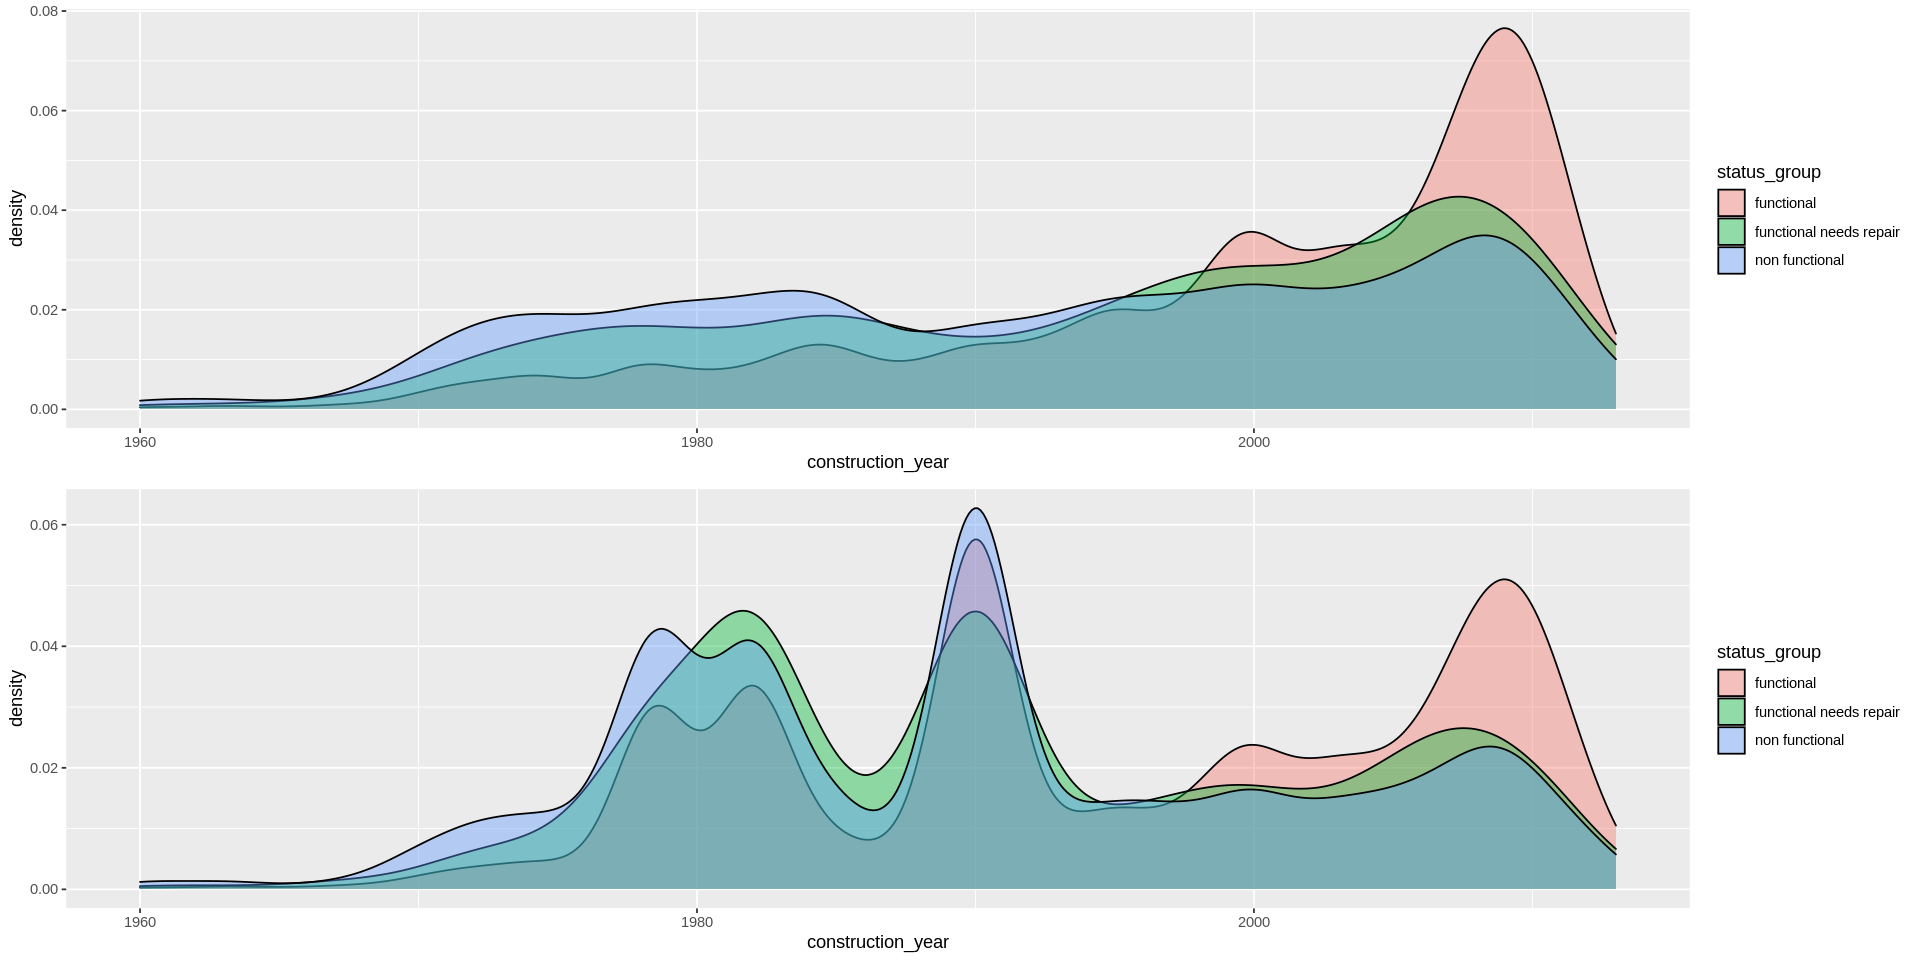

In [64]:
options(repr.plot.width=16, repr.plot.height=8,warn = -1)
#filtrar valores nulos en las variables originales, evitando asi la distorsion.
orig_cons = filter(DF%>% filter(status_group!='tst'), construction_year != 0)
const_org <-ggplot(orig_cons, aes(x=construction_year,fill=status_group)) + 
  geom_density(alpha=0.4)

const <-ggplot(input%>% filter(status_group!='tst'), aes(x=construction_year,fill=status_group)) + 
  geom_density(alpha=0.4)

multiplot(const_org,const,cols=1)



```
Imputar el año de construccion por la mediana, ha creado dos deformaciones 
que no respetan la tendencia general de la curva de densidad.
Habria que pensar en una imputacion mas aleatoria.
```



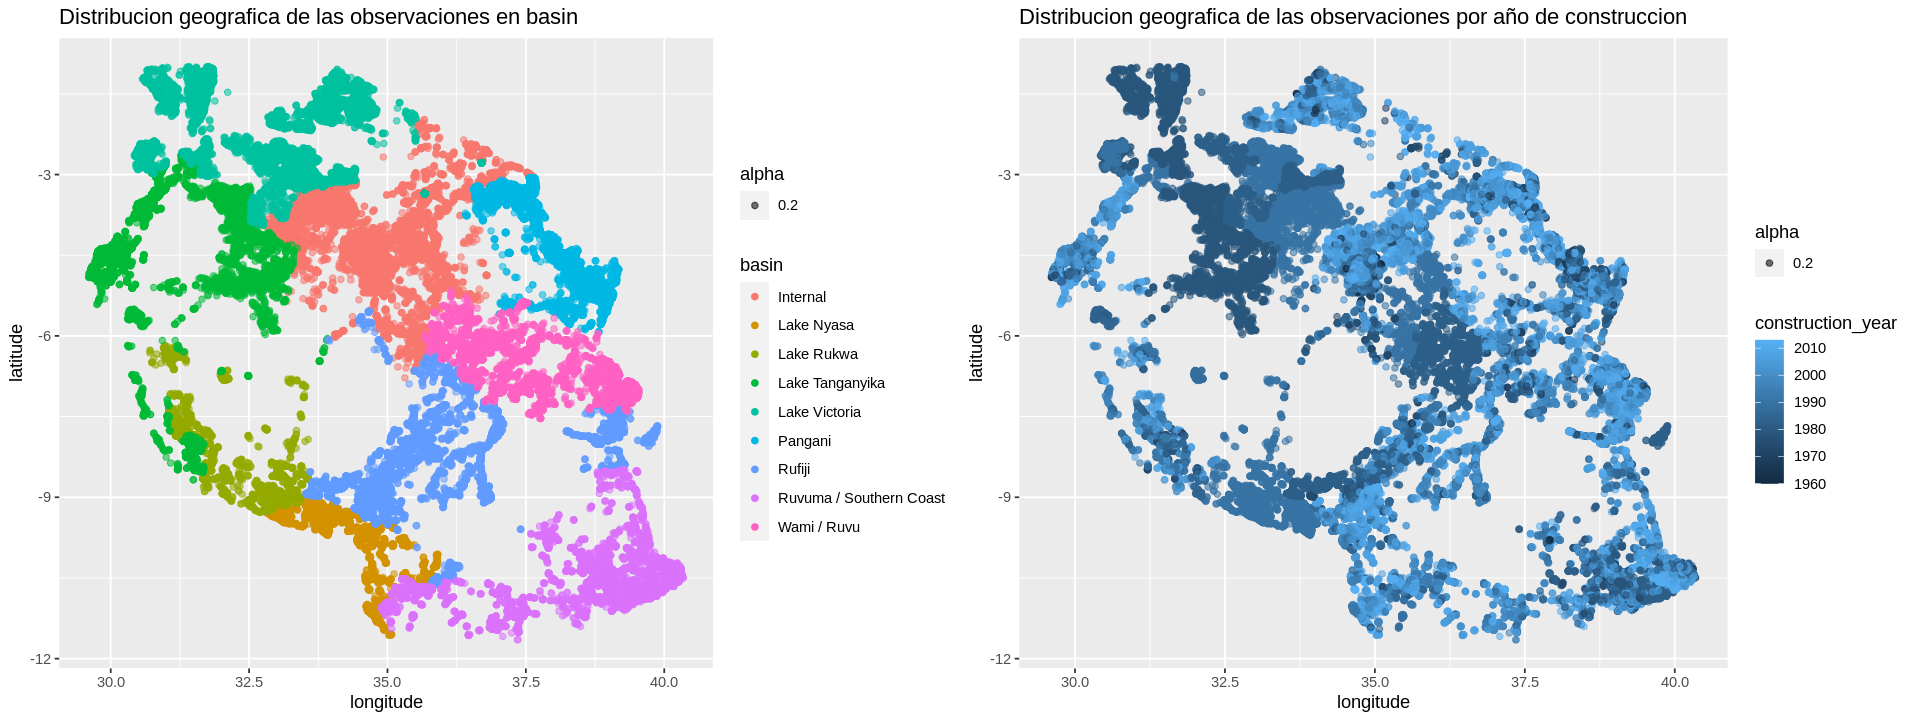

In [65]:
options(repr.plot.width=16, repr.plot.height=6,warn = -1)
dff = ggplot(input, aes(x=longitude, y=latitude, color = basin,alpha=0.2)) +
  geom_point()+
  ggtitle("Distribucion geografica de las observaciones en basin")
ddg = ggplot(input, aes(x=longitude, y=latitude, color = construction_year,alpha=0.2)) +
  geom_point()+
  ggtitle("Distribucion geografica de las observaciones por año de construccion")
multiplot(dff,ddg,cols =2)

Los datos faltantes de construction_year, se concentran en zonas concretas del
interior.  
Vamos a imputar esos valores agrupando por basin, porque si eligimos \\
una delimitacion mas reducida, habria muchas que son sin datos.


#### Date recorded

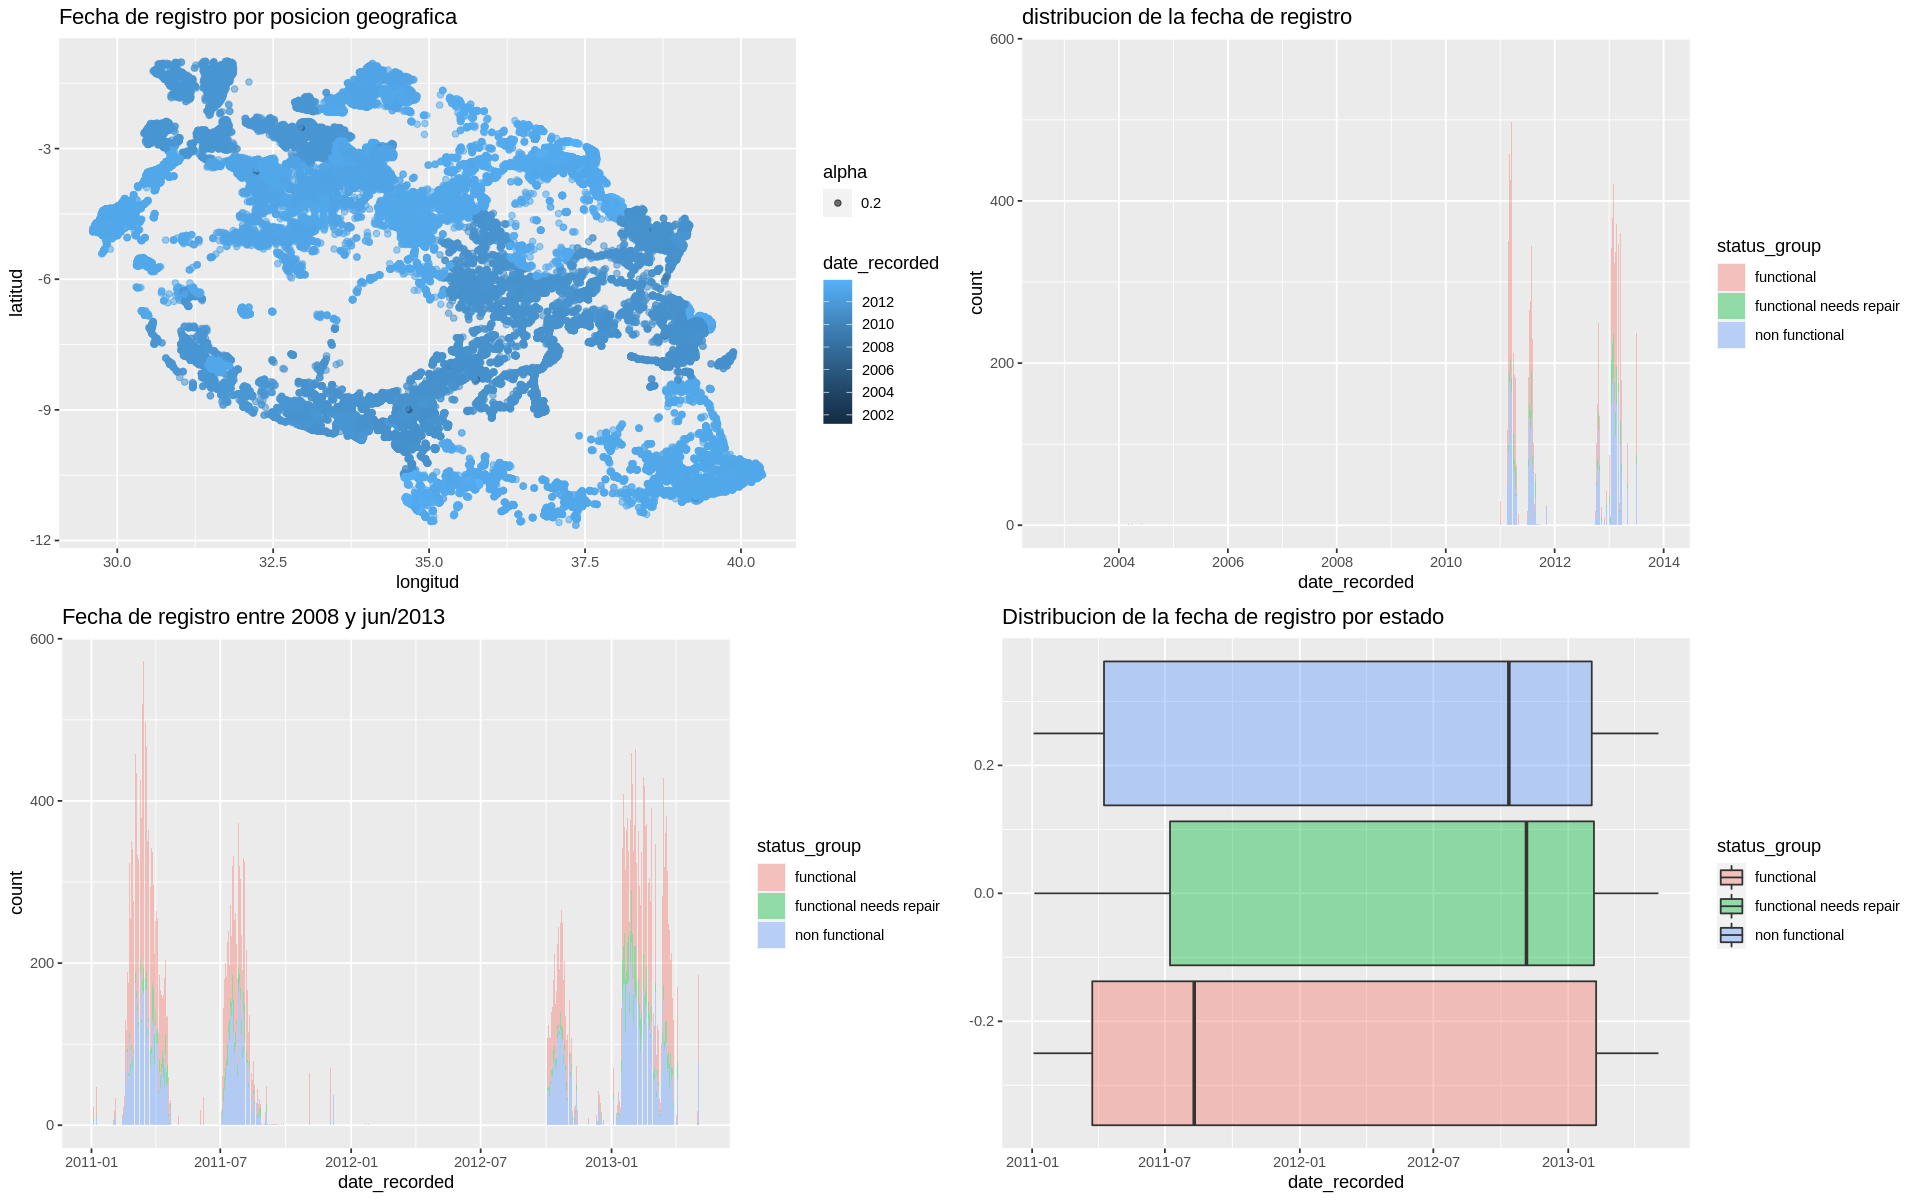

In [66]:
options(repr.plot.width=16, repr.plot.height=10,warn = -1)
#visualizamos en el mapa, para distingiur patornes
fch = ggplot(input, aes(x=longitude, y=latitude, color = date_recorded,alpha=0.2)) +
  geom_point()+ ggtitle("Fecha de registro por posicion geografica") +
  xlab("longitud") + ylab("latitud")

rec = ggplot(input%>% filter(status_group!='tst'), aes(x=date_recorded,fill=status_group)) + 
  geom_bar(alpha=0.4)+ggtitle('distribucion de la fecha de registro')

rec_ = filter(input, date_recorded > '2008-01-01'& date_recorded < '2013-06-01' & status_group!='tst')
rec_2 = ggplot(rec_, aes(x=date_recorded,fill=status_group)) + 
  geom_bar(alpha=0.4)+ggtitle('Fecha de registro entre 2008 y jun/2013')

bxp = ggplot(rec_, aes(x=date_recorded,fill=status_group)) + 
  geom_boxplot(alpha=0.4)+ ggtitle("Distribucion de la fecha de registro por estado")

multiplot(fch,rec_2,rec,bxp, cols = 2)

In [67]:
input = input %>%
     mutate(date_recorded = replace(date_recorded, year(date_recorded) == 2002  , '2012-01-01')) %>%
     mutate(date_recorded = replace(date_recorded, year(date_recorded) == 2003  , '2013-01-01')) %>%
     mutate(date_recorded = replace(date_recorded, year(date_recorded) == 2004  , '2014-01-01')) 



```
En el primer grafico, hemos cruzado la date_recorded con las coordenadas, 
y podemos ver como las mas antiguas ocupan areas bien diferenciadas de las 
mas recientes.

En el segundo grafico (superior dcha), hay unos pocos valores(outliers) 
que sesgan la muestra hacia la izquierda y cuando los filtramos obtenemos 
un grafico (inferior izq) mas definido, en cuatro bloques de fechas en las 
que se han hecho los registros.

En el ultimo grafico, se muestra la distribucion(caja y bigote) de las fechas 
de registro, cruzadas con el estado del pozo. Se aprecia la diferencia 
entre 'functional' cuyas mediana se encuentra a mediados de 2011(algo mas 
tarde), y las de 'functional needs repair' y 'non functional' se encuentra 
a finales de 2013. Lo que indica que esta variable puede tener potencial en 
la prediccion de status_group.  
```



### Population



```
La variable population, esta desbalanceada como se muestra en el siguiente
grafico, y tiene muchos datos faltantes. Podemos suponer que si hay un pozo, 
es que hay habitantes. los valores 0 por lo tanto son en realidad NA's. Lo mismo ocurre  con los valores 1, que son los segundos mas frecuentes.

seguiremos el mismo metodo que en las variables numericas anteriores
reemplazaremos en la medida d lo  posible, los datos faltantes por las medias
, agrupando por la delimitacion de territorio mas pequeña, a la mas 
grande, asumiendo con ello un sesgo en la muestra.

```



In [ ]:
head(questionr::freq(input$population,sort = "dec"),5)  

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,26834,36.1,36.1
1,8782,11.8,11.8
200,2370,3.2,3.2
150,2328,3.1,3.1
250,2087,2.8,2.8


In [68]:
pop_impt = merge (input,
            input %>%
                select(population,lga)%>%
                group_by(lga)%>%
                summarize(median_pop = median(population, na.rm = TRUE)),
            by = 'lga')
pop_impt = merge (pop_impt,
            input %>%
                select(population,subvillage)%>%
                group_by(subvillage)%>%
                summarize(median_pop_vil = median(population, na.rm = TRUE)),
            by = 'subvillage')

pop_impt <- pop_impt %>%
               mutate(population = replace(population, population == 0 , median_pop))%>%
               mutate(population = replace(population, population == 1 , median_pop))%>%
               mutate(population = replace(population, population == 0 , median_pop_vil))%>%
               mutate(population = replace(population, population == 1 , median_pop_vil))
input = pop_impt[,1:(ncol(pop_impt)-2)]

In [ ]:
head(questionr::freq(input$population,sort = "dec"),5) 

,n,%,val%
,<dbl>,<dbl>,<dbl>
0,8853,11.9,11.9
200,3914,5.3,5.3
250,3882,5.2,5.2
150,3758,5.1,5.1
300,2744,3.7,3.7


## Feature Engineering

### Variables numericas



```
Realizaremos a continuacion unas transformaciones para cambiar las 
distribuciones de los datos en cada columna numerica, de tal forma 
que se maximize la relacion que tienen con la variable objetivo.
```



In [70]:

# Busca la transformación de variables input de intervalo que maximiza la V de Cramer con la objetivo 
mejorTransfVcramer<-function(vv,target){
  vv<-scale(vv)
  vv<-vv+abs(min(vv,na.rm=T))*1.0001
  posiblesTransf<-data.frame(x=vv,logx=log(vv),expx=exp(vv),sqrx=vv^2,sqrtx=sqrt(vv),cuartax=vv^4,raiz4=vv^(1/4))
  return(list(colnames(posiblesTransf)[which.max(apply(posiblesTransf,2,function(x) Vcramer(x,target)))],posiblesTransf[,which.max(apply(posiblesTransf,2,function(x) Vcramer(x,target)))]))
}

# Detecta el tipo de variable objetivo y busca la mejor transformación de las variables input continuas automáticamente
Transf_Auto<-function(matriz,target){
  aux<-data.frame(apply(matriz,2,function(x) mejorTransfVcramer(x,target)[[2]]))
  aux2<-apply(matriz,2,function(x) mejorTransfVcramer(x,target)[[1]])   
  names(aux)<-paste0(aux2,names(aux2))

  return(aux)
}

In [72]:
#nos quedamos con las variables numericas, le aplicamos la transformacion 
#automatica, y las juntamos al dataframe original.
i = Filter(is.numeric,input)
tr = Transf_Auto(i,input$status_group)
input_bin<-cbind(input,tr,input$status_group)

In [79]:
colnames(input_bin)[40] = 'status_group'

[1] "subvillage"         "lga"                "basin"             
 [4] "region"             "id"                 "amount_tsh"        
 [7] "date_recorded"      "gps_height"         "longitude"         
[10] "latitude"           "region_code"        "district_code"     
[13] "population"         "public_meeting"     "permit"            
[16] "construction_year"  "funder"             "installer"         
[19] "wpt_name"           "ward"               "scheme_management" 
[22] "scheme_name"        "extraction_type"    "management"        
[25] "payment"            "water_quality"      "quantity"          
[28] "source"             "waterpoint_type"    "status_group"      
[31] "expxid"             "logxamount_tsh"     "sqrtxgps_height"   
[34] "sqrtxlongitude"     "sqrtxlatitude"      "raiz4region_code"  
[37] "xdistrict_code"     "logxpopulation"     "xconstruction_year"
[40] "V3"

###dates

In [81]:
# elimino variables que no sirven
input_bin$expxid = NULL
input_bin$raiz4region_code = NULL
input_bin$xdistrict_code =NULL
#quiatmos variables con demasiadas categorias
input_bin$scheme_name = NULL
input_bin$wpt_name = NULL
# vamos a quitar las variables categoricas de delimitaciones geograficas ,
# nos quedaremos con las coordenadas
input_bin$district_code= NULL
input_bin$region=NULL
input_bin$region_code=NULL
input_bin$subvillage=NULL
input_bin$ward= NULL

In [82]:
# creamos una cuenta atras del año de date recorded.
input_bin$dias_transcurridos  <- as.numeric(max(ymd(input_bin$date_recorded)) - ymd(input_bin$date_recorded))

In [83]:
# extraemos los meses y años de registro respectivamente, y los juntamos al
# dataframe como nuevas columnas.
input_bin$mes = as.numeric(month(ymd(input_bin$date_recorded)))
input_bin$anio = as.numeric(year(ymd(input_bin$date_recorded)))

In [84]:
#eliminamos la variable date_recorded, ya no nos sirve.
input_bin$date_recorded = NULL

### One_hot

In [87]:
#convertimos region_code y district_code a factor ya que son claramente
# categoricas nominales.
input_bin$region_code = as.factor(input_bin$region_code)
input_bin$district_code = as.factor(input_bin$district_code)

In [88]:
# separamos el dataframe por tipo de variable, para hacer 
# las transformaciones  a cada tipo por separado.
#tipo character
char_ = input_bin%>% select_if(is.character)

#tipo logical
log_ = input_bin%>% select_if(is.logical)

#tipo numeric
num_ = input_bin%>% select_if(is.numeric)
num_sin_trnsf = num_[,1:7]
num_trnsf = num_[,8:16]

#tipo factor
fact_ = input_bin%>% select_if(is.factor)

#dimensiones de cada tipo
dim(char_)
dim(log_)
dim(num_)
dim(input_bin)

[1] 74250    14

[1] 74250     2

[1] 74250    16

[1] 74250    34

In [92]:
library(data.table)

dfreq = setDT(char_[,c('lga','basin','source')])
#reemplazamos las categorias de las variables de dfreq por sus 
#frecuencias respectivas.
dfreq[ , lga_f := .N , by = .(lga)]
dfreq[ , basin_f := .N , by = .(basin)]
dfreq[ , source_f := .N , by = .(source)]

dfreq = as.data.frame(dfreq[,4:6])
char_[,c('lga','basin','source')] = NULL

####log

In [93]:
# le asignamos unos y zeros a las variables de tipo logical
# en vez de True y False, ya que el modelo necesita valores numericos
# y en algunos casos solo se pueden procesar datos numericos.
log_$permit = ifelse(log_$permit == T, 1,0)
log_$permit = replace(log_$permit,is.na(log_$permit),'')

In [94]:
log_$public_meeting = ifelse(log_$public_meeting == T, 1,0)
log_$public_meeting = replace(log_$public_meeting,is.na(log_$public_meeting),'')

In [95]:
#convertir las dos columnas logicas a factor
log_ %<>% mutate_each_(funs(factor(.)),names(log_))

In [97]:
#convertimos la columnas () a label encoding
to_fact = char_[,c('funder','installer','scheme_management',
'extraction_type','management','waterpoint_type')]
char_1 <- map_df(to_fact, function(columna) {
  columna %>% #itera sobre columna
    as.factor() %>% # convierte a factor primero
    as.numeric #convierte a numerico
})

In [102]:
#Creamos 3 variables dummies payment, quantity y water quality
cat_dum = char_[,c('payment','quantity','water_quality')]
char_2_dum <- dummy_cols(cat_dum, select_columns = c('payment','quantity','water_quality') , remove_first_dummy = TRUE)
#aqui tendremos que borrar las columnas convertidas a dummy
char_2_dum[,c('payment','quantity','water_quality')] = NULL

In [108]:
colnames(char_2_dum)[1:5] = c('payment_never_pay','payment_annually','payment_monthly','payment_bucket','payment_scheme_fails')
colnames(char_2_dum)[11] = 'water_quality_fluoride_abandoned'
colnames(char_2_dum)[15] = 'water_quality_salty_abandoned'

In [116]:
# volvemos a juntar las partes despues de haber hecho las transformaciones.
df_ = cbind(num_trnsf,num_sin_trnsf,dfreq,char_1,char_2_dum,log_,char_$status_group)

In [118]:
#cambiamos el nombre de la columna
colnames(df_)[44] = 'status_group'

In [120]:
# separamos entre la parte para hacer predicciones y la otra para entrenamiento
para_pred =  df_%>% filter(status_group == 'tst')
df_ = df_%>% filter(status_group != 'tst')
para_pred$status_group = NULL

In [ ]:
#guardamos los datasets
# RDS es bastante mas rapido en cargarse.
saveRDS(df_,'trn_set.rds')
saveRDS(para_pred,'pred_def.rds')

#Modelado

###cargar datasets:

In [5]:
#cargamos dataset para entrenamiento
df_ = readRDS('trn_set.rds')

In [6]:
str(df_)#veamos que todas las variables tienen el tipo correcto.

Classes ‘data.table’ and 'data.frame':	59400 obs. of  44 variables:
 $ logxamount_tsh                  : num  -10.246 -10.246 0.874 -10.246 -10.246 ...
 $ sqrtxgps_height                 : num  1.52 1.46 1.45 1.68 1.68 ...
 $ sqrtxlongitude                  : num  0.848 1.264 1.146 1.133 1.143 ...
 $ sqrtxlatitude                   : num  1.9 1.87 1.81 1.81 1.82 ...
 $ logxpopulation                  : num  -9.81 -0.644 0.231 -0.397 -0.397 ...
 $ xconstruction_year              : num  1.56 3.79 2.44 2.53 2.53 ...
 $ dias_transcurridos              : num  909 382 896 896 896 901 898 896 896 901 ...
 $ mes                             : num  7 12 7 7 7 7 7 7 7 7 ...
 $ anio                            : num  2011 2012 2011 2011 2011 ...
 $ id                              : int  4541 19461 1778 3762 4512 5879 6182 6416 7145 7415 ...
 $ amount_tsh                      : num  0 0 500 0 0 0 0 1000 0 0 ...
 $ gps_height                      : num  1400 1281 1260 1720 1720 ...
 $ longitude      

In [7]:
# como modelo inicial podemos partir de las observaciones sin valores 
# faltantes.
df_ = df_[complete.cases(df_), ]
dim(df_)

[1] 59400    44

In [8]:
#------------------------------- TRAIN -TEST - SPLIT 
# partimos los datos en 80/20% train/test.
set.seed(7)
validationIndex <- createDataPartition(df_$status_group, p=0.8, list=FALSE)

In [9]:
# asignamos la parte de test
my_test  <- df_[-validationIndex,]
#asignamos la parte de train 80% 
my_train <- df_[validationIndex,]

In [10]:
dim(my_train)

[1] 47522    44

In [11]:
# separamos las variables independientes de la variable objetivo
tr = my_train %>% select(-one_of('status_group'))
tr$id =NULL#quitamos la columna id
myVarObj = as.factor(my_train$status_group)

In [ ]:
# Semilla para reproducibilidad.
set.seed(1)

# Modelo Random Forest con Ranger.
my_model <- ranger(
        myVarObj ~.,# target ~ variables independientes
        importance = "impurity",
        num.trees = 1000,
        mtry = 7,
        data = tr,
        na.action=na.omit
)

In [321]:
my_model$confusion.matrix

                         predicted
true                      functional functional needs repair non functional
  functional                   22838                     612           2358
  functional needs repair       1742                    1161            551
  non functional                3642                     287          14331

In [ ]:
#modelo con las variables transformadas
my_model1 <- ranger(
        myVarObj ~.,
        importance = "impurity",
        num.trees = 1000,
        mtry = 7,
        data = tr[,10:dim(tr)[2]],
        na.action=na.omit
)

In [319]:
my_model1$confusion.matrix

                         predicted
true                      functional functional needs repair non functional
  functional                   22974                     563           2271
  functional needs repair       1812                    1101            541
  non functional                3808                     247          14205

In [ ]:
#un modelo sin las variables no transformadas
my_model2 <- ranger(
        myVarObj ~.,
        importance = "impurity",
        num.trees = 1000,
        mtry = 7,
        data = tr[,- c(10:15)],
        na.action=na.omit
)

In [318]:
my_model2$confusion.matrix

                         predicted
true                      functional functional needs repair non functional
  functional                   22968                     575           2265
  functional needs repair       1766                    1151            537
  non functional                3680                     267          14313

In [27]:
# mostramos lista de la importancia de las variables en el modelo2
# ordenadas por importancia de mayor a menor.
head(as.data.frame(my_model2$variable.importance),12)

,my_model2$variable.importance
,<dbl>
logxamount_tsh,478.9859
sqrtxgps_height,1617.9236
sqrtxlongitude,2518.2416
sqrtxlatitude,2497.6813
logxpopulation,1471.3959
xconstruction_year,1441.3341
dias_transcurridos,1543.9744
mes,477.1939
anio,143.4159


In [28]:
# realizamoas las predicciones sobre el test con el modelo2
my_predict2 <- predict(my_model2, data = my_test)
pred_status_group <- my_predict2$predictions
#mostramos una matriz de confusion entre los valores predichos y reales
table(my_predict2$predictions,my_test$status_group)

                         
                          functional functional needs repair non functional
  functional                    5763                     451            919
  functional needs repair        138                     267             66
  non functional                 550                     145           3579

```
los datos acertados son los que dibujan una diagonal de la esquina 
superior izquierda hacia la opuesta. el resto son falsos negativos, y 
falsos positivos.
los valores predichos son las columnas , y las filas son los reales. En 
la columna functional por ejemplo, el primer valor predijo functional y era 
el caso, sin embargo en la segunda fila, predijo functional y en realidad 
era functional needs repair.
```




In [ ]:
# este paquete calcula diferentes tipos de metricas referentes al machine learning.
install.packages('MLmetrics')
library(MLmetrics)

In [30]:
#calculamos la precision de nuestro modelo
fit_acc2 <- MLmetrics::Accuracy(y_pred = my_predict2$predictions, y_true = my_test$status_group)
sprintf("La precision de nuestro modelo 2 es del  %s pct",round(fit_acc2,3))

[1] "La precision de nuestro modelo 2 es del  0.809 pct"

###XGBoost

In [241]:
#Hacemos particion de los datos
tr_org<- sample_frac(df_, size = 0.7)
tst_org <- setdiff(df_, tr_org)

In [242]:
#convertimos todas las columnas a numerico, porque xgboost solo funciona con 
# matrices de numeros
original <- map_df(tr_org, function(columna) {
  columna %>% 
    as.factor() %>% 
    as.numeric %>% 
    { . -1  }
})

In [243]:
# convertimos el dataframe de numericos a matriz, señalando la variable objetivo.
tr_mat <- 
  original %>% 
  select(-status_group) %>% 
  as.matrix() %>% 
  xgb.DMatrix(data = ., label =original$status_group)

In [244]:
#numero de categorias en la variable target
numberOfClasses <- length(unique(df_$status_group))
# asignamos los hiperparametros al modelo
xgb_params <- list("objective" = "multi:softprob",
                   "eval_metric" = "mlogloss",
                   "num_class" = numberOfClasses)
nround    <- 20 # number of XGBoost rounds
cv.nfold  <- 5

# Fit cv.nfold * cv.nround XGB models and save OOF predictions
cv_model <- xgb.cv(params = xgb_params,
                   data = tr_mat, 
                   nrounds = nround,
                   nfold = cv.nfold,
                   verbose = FALSE)
                   #prediction = TRUE)

###test xgb

In [245]:
#preparamos los datos del test para hacer nuestra prediccion
original2 <- map_df(tst_org, function(columna) {
  columna %>% 
    as.factor() %>% 
    as.numeric %>% 
    { . -1  }
})
ts_mat <- 
  original2 %>% 
  select(-status_group) %>% 
  as.matrix() %>% 
  xgb.DMatrix(data = ., label =original2$status_group)

In [246]:
bst_model <- xgb.train(params = xgb_params,
                       data = tr_mat,
                       nrounds = nround)
test_label = original2$status_group
# predecimos los valores del test 20% que hemos guardado previamente.
test_pred <- predict(bst_model, newdata = ts_mat)
test_prediction <- matrix(test_pred, nrow = numberOfClasses,
                          ncol=length(test_pred)/numberOfClasses) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_label + 1,
         max_prob = max.col(., "last"))
# matriz de confusion del test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3
         1 8787  873 2555
         2   82  168   44
         3  858  229 4224

Overall Statistics
                                         
               Accuracy : 0.7396         
                 95% CI : (0.7331, 0.746)
    No Information Rate : 0.5458         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.4899         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.9034 0.132283   0.6191
Specificity            0.5764 0.992387   0.9012
Pos Pred Value         0.7194 0.571429   0.7953
Neg Pred Value         0.8323 0.937122   0.7922
Precision              0.7194 0.571429   0.7953
Recall                 0.9034 0.132283   0.6191
F1                     0.8009 0.214834   0.6962
Prevalence             0.5458 0.071268

Nuestro modelo tiene una accuracy del 74 %.

### Modelo con balanceo de la variable status group

```
Aqui he intentado balancear el dataset para que la variable objetivo no 
tenga frecuencias de clases tan dispares, pero por alguna razon no reconoce la 
primera clase.
```




In [ ]:
install.packages('UBL')
library(UBL)

In [178]:
#Hacemos particion de los datos
tr_smt <- sample_frac(df_, size = 0.7)
tst_smt <- setdiff(df_, tr_org)

In [189]:
#cambiamos los tipose a numerico
prueba <- map_df(tr_smt, function(columna) {
  columna %>% 
    as.factor() %>% 
    as.numeric %>% 
    { . -1  }
})

In [190]:

## usamos SMOTE to create a more "balanced problem"
#newData <- SmoteClassif(status_group ~ ., tr_smt, C.perc="balance",dist="HEOM")
#table(newData$status_group)
newData <- smotefamily::SMOTE(prueba[,- 44],prueba$status_group,K = 5)


In [199]:
# seleccionamos los datos
newData = newData$data
colnames(newData)[44] = 'status_group'
table(newData$status_group)
#vemos que el algoritmo smote ha balanceado las clases correctamente.
# ya que las ocurrencias por clase no son distintas entre si.


    0     1     2 
22544 36228 16017 

In [325]:
#convertimos todas las columnas a numerico, porque xgboost solo funciona con 
# matrices de numeros
original_smt <- map_df(newData, function(columna) {
  columna %>% 
    as.factor() %>% 
    as.numeric %>% 
    { . -1  }
})
# convertimos el dataframe de numericos a matriz, señalando la variable objetivo.
tr_mat_smt <- 
  original_smt %>% 
  select(-status_group) %>% 
  as.matrix() %>% 
  xgb.DMatrix(data = ., label =original_smt$status_group)


numberOfClasses <- length(unique(df_$status_group))
xgb_params <- list("objective" = "multi:softprob",
                   "eval_metric" = "mlogloss",
                   "num_class" = numberOfClasses)
nround    <- 20 # number of XGBoost rounds
cv.nfold  <- 5

# Fit cv.nfold * cv.nround XGB models and save OOF predictions
cv_model <- xgb.cv(params = xgb_params,
                   data = tr_mat_smt, 
                   nrounds = nround,
                   nfold = cv.nfold,
                   verbose = FALSE)
                   #prediction = TRUE)

In [326]:
#preparamos los datos del test para hacer nuestra prediccion
original_smt_tst <- map_df(tst_smt, function(columna) {
  columna %>% 
    as.factor() %>% 
    as.numeric %>% 
    { . -1  }
})
ts_mat_smt <- 
  original_smt_tst %>% 
  select(-status_group) %>% 
  as.matrix() %>% 
  xgb.DMatrix(data = ., label =original_smt_tst$status_group)

In [327]:
bst_model_smt <- xgb.train(params = xgb_params,
                       data = tr_mat_smt,
                       nrounds = nround)
test_label = original_smt_tst$status_group
# Predict hold-out test set
test_pred_smt <- predict(bst_model_smt, newdata = ts_mat_smt)
test_prediction_smt <- matrix(test_pred_smt, nrow = numberOfClasses,
                          ncol=length(test_pred_smt)/numberOfClasses) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_label+ 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction_smt$max_prob),
                factor(test_prediction_smt$label),
                mode = "everything")


Confusion Matrix and Statistics

          Reference
Prediction    1    2    3
         1    0    0    0
         2 8751 1155 4539
         3  902  169 2304

Overall Statistics
                                       
               Accuracy : 0.1941       
                 95% CI : (0.1883, 0.2)
    No Information Rate : 0.5417       
    P-Value [Acc > NIR] : 1            
                                       
                  Kappa : 0.0705       
                                       
 Mcnemar's Test P-Value : <2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.0000  0.87236   0.3367
Specificity            1.0000  0.19435   0.9024
Pos Pred Value            NaN  0.07996   0.6827
Neg Pred Value         0.4583  0.94993   0.6858
Precision                  NA  0.07996   0.6827
Recall                 0.0000  0.87236   0.3367
F1                         NA  0.14649   0.4510
Prevalence             0.5417  0.07430   0.3840
Detectio



```
Este modelo no reconoce la la clase uno.
no he conseguido encontrar la razon.
```



###guardamos el submission format

In [ ]:
#guardar el modelo
#modelo = readRDS(my_model, "modelo.rds")

In [285]:
#cargar los datos para predecir
subm = readRDS('pred_def.rds')
#sub_pred$predictions
s = fread('SubmissionFormat.csv')

In [ ]:
library(plyr)

In [286]:
# predecimos los valores en el dataframe de submission
sub_pred = predict(my_model2, data = subm)

In [287]:
#seleccionamos los valores predichos y sus ids.
subm_df = cbind.data.frame(subm$id,sub_pred$predictions)
colnames(subm_df) = c('id','status_group1')

In [ ]:
#juntamos el submissionformat con nuestras predicciones
df2_sub = join(s,subm_df)[,c(1,3)]

In [299]:
#cambiamos nombre de columna
colnames(df2_sub)[2] = 'status_group'

In [301]:
#guardamos las predicciones en un csv
fwrite(df2_sub,'SubmissionFormat.csv')

###Submission

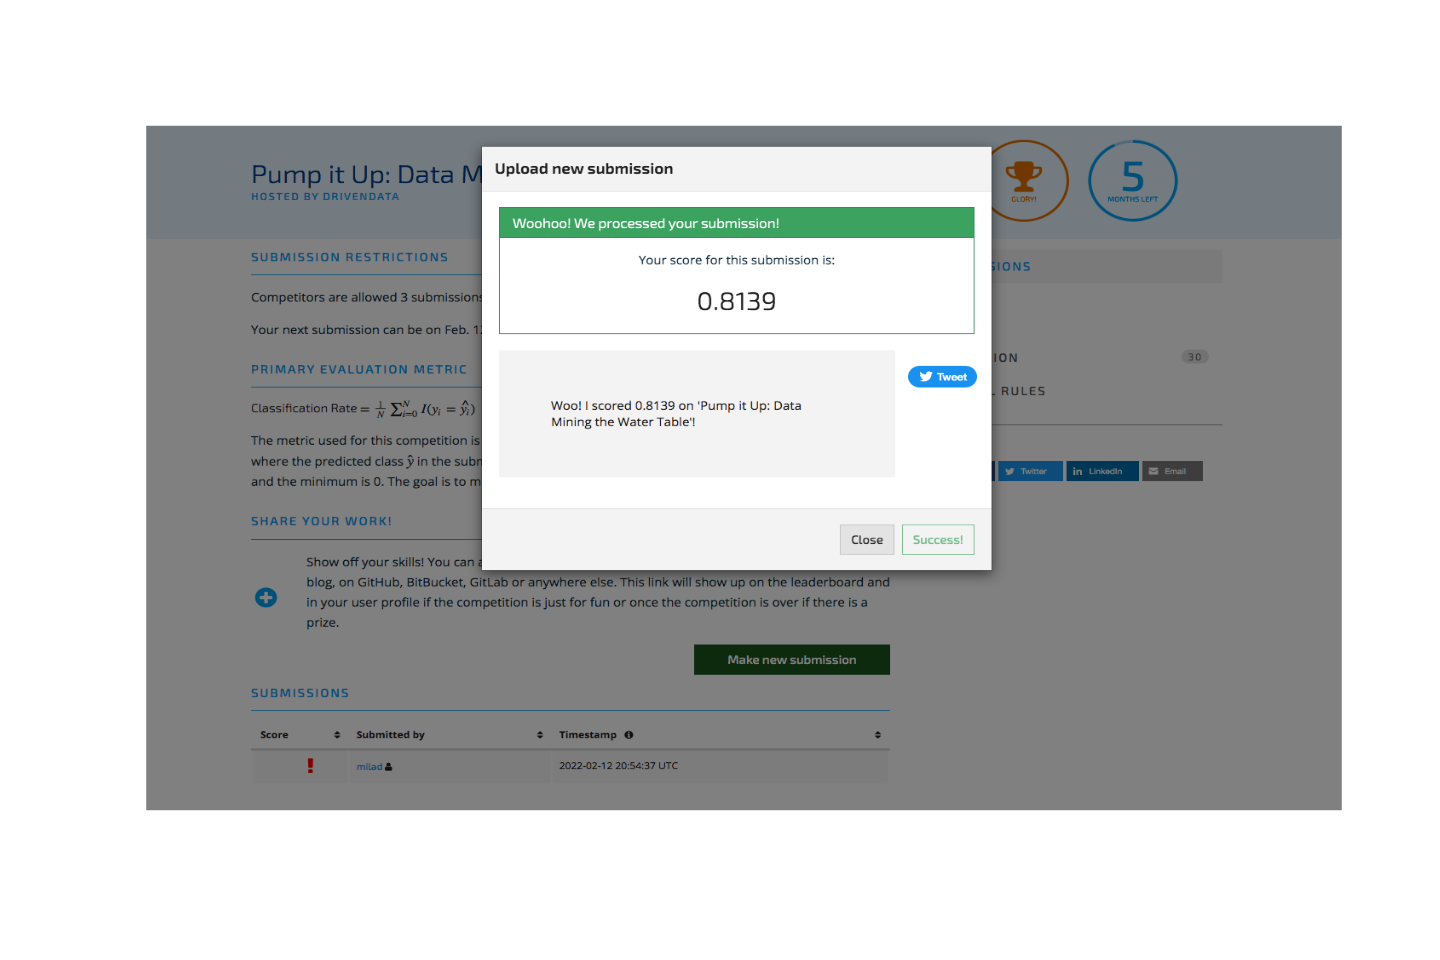

In [316]:
options(repr.plot.width=12, repr.plot.height=8)

#imagen de la submission en la pagina del concurso
pil_im = 'captura_subm1.png'
pil_im2 = 'captura_subm2.png'
p1 <- readPNG(pil_im)
p2 <- readPNG(pil_im2)
plot.new() 
rasterImage(p1,0,0,1,1)